In [6]:
import math
import os
import sys
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'
import multiprocessing
import parmap
import numpy as np
import collections
from tqdm.notebook import tqdm
import pandarallel
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=20, progress_bar=True)
# tqdm.pandas()
from pprint import pprint
from scipy.stats import zscore
import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mc
from matplotlib.colors import LogNorm
sys.path.append('..')
from src.utils.utils import load_config_file
import json

import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'


INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [2]:
# omim_gene_level = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/matrix_omim_gene_level.xlsx')
omim_gene_level = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/matrix_omim_gene_level_corrected.xlsx')
# omim_gene_level = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/matrix_omim_gene_level_wt_brain.xlsx')
omim_gene_level

,symbol,OMIM_pheno_gene_level,OMIM_pheno_name_gene_level,Tissue_gene_level,Supertissue,OMIM_body_part_gene_level,OMIM_details_gene_level
0,AK2,267500,Reticular dysgenesis,Cells - EBV-transformed lymphocytes,Cells,immunology,"['Lymphoid hypoplasia', 'Thymic hypoplasia', '..."
1,SLC25A13,603471,"Citrullinemia, adult-onset type II",Liver,Liver,abdomenLiver,"['Nonalcoholic fatty liver disease', 'Hepatic ..."
2,SLC25A13,605814,"Citrullinemia, type II, neonatal-onset",Liver,Liver,abdomenLiver,"['Intrahepatic cholestasis', 'Elevated bilirub..."
3,ABCB4,614972,"Cholestasis, intrahepatic, of pregnancy, 3",Liver,Liver,abdomenLiver,"['Intrahepatic cholestasis during pregnancy, r..."
4,ABCB4,602347,"Cholestasis, progressive familial intrahepatic 3",Liver,Liver,abdomenLiver,"['Intrahepatic cholestasis', 'Jaundice', 'Hepa..."
...,...,...,...,...,...,...,...
901,RTEL1,615190,"Dyskeratosis congenita, autosomal recessive 5",Brain - Cerebellum,Brain,headAndNeckHead,['Microcephaly']
902,TUBB3,614039,"Cortical dysplasia, complex, with other brain ...",Brain - Frontal Cortex (BA9),Brain,headAndNeckHead,['Microcephaly (in some patients)']
903,TUBB3,614039,"Cortical dysplasia, complex, with other brain ...",Brain - Hypothalamus,Brain,headAndNeckHead,['Microcephaly (in some patients)']
904,TUBB3,600638,"Fibrosis of extraocular muscles, congenital, 3A",Brain - Frontal Cortex (BA9),Brain,headAndNeckHead,['Compensatory chin elevation']


In [3]:
print(omim_gene_level.symbol.nunique())
print(omim_gene_level[['OMIM_pheno_gene_level', 'symbol']].drop_duplicates().shape[0])

531
682


In [2]:
omim_global_dict = {
    "abdomenBiliaryTract": "abdomen",
    "abdomenExternalFeatures": "abdomen",
    "abdomenGastrointestinal": "abdomen",
    "abdomenLiver": "abdomen",
    "abdomenPancreas": "abdomen",
    "abdomenSpleen": "abdomen",
    "cardiovascularHeart": "cardiovascular",
    "cardiovascularVascular": "cardiovascular",
    "chestBreasts": "chest",
    "chestDiaphragm": "chest",
    "chestExternalFeatures": "chest",
    "chestRibsSternumClaviclesAndScapulae": "chest",
    "endocrineFeatures": "endocrineFeatures",
    "genitourinaryBladder": "genitourinary",
    "genitourinaryExternalGenitaliaFemale": "genitourinary",
    "genitourinaryExternalGenitaliaMale": "genitourinary",
    "genitourinaryInternalGenitaliaFemale": "genitourinary",
    "genitourinaryInternalGenitaliaMale": "genitourinary",
    "genitourinaryKidneys": "genitourinary",
    "genitourinaryUreters": "genitourinary",
    "growthHeight": "growth",
    "growthOther": "growth",
    "growthWeight": "growth",
    "headAndNeckEars": "headAndNeck",
    "headAndNeckEyes": "headAndNeck",
    "headAndNeckFace": "headAndNeck",
    "headAndNeckHead": "headAndNeck",
    "headAndNeckMouth": "headAndNeck",
    "headAndNeckNeck": "headAndNeck",
    "headAndNeckNose": "headAndNeck",
    "headAndNeckTeeth": "headAndNeck",
    "hematology": "hematology",
    "immunology": "immunology",
    "inheritance": "inheritance",
    "laboratoryAbnormalities": "laboratoryAbnormalities",
    "metabolicFeatures": "metabolicFeatures",
    "miscellaneous": "miscellaneous",
    "molecularBasis": "molecularBasis",
    "muscleSoftTissue": "muscleSoftTissue",
    "neoplasia": "neoplasia",
    "neurologicBehavioralPsychiatricManifestations": "neurologic",
    "neurologicCentralNervousSystem": "neurologic",
    "neurologicPeripheralNervousSystem": "neurologic",
    "prenatalManifestationsAmnioticFluid": "prenatalManifestations",
    "prenatalManifestationsDelivery": "prenatalManifestations",
    "prenatalManifestationsMaternal": "prenatalManifestations",
    "prenatalManifestationsMovement": "prenatalManifestations",
    "prenatalManifestationsPlacentaAndUmbilicalCord": "prenatalManifestations",
    "respiratoryAirways": "respiratory",
    "respiratoryLarynx": "respiratory",
    "respiratoryLung": "respiratory",
    "respiratoryNasopharynx": "respiratory",
    "skeletalFeet": "skeletal",
    "skeletalHands": "skeletal",
    "skeletalLimbs": "skeletal",
    "skeletalPelvis": "skeletal",
    "skeletalSkull": "skeletal",
    "skeletalSpine": "skeletal",
    "skinNailsHairHair": "skinNailsHair",
    "skinNailsHairNails": "skinNailsHair",
    "skinNailsHairSkin": "skinNailsHair",
    "skinNailsHairSkinElectronMicroscopy": "skinNailsHair",
    "skinNailsHairSkinHistology": "skinNailsHair",
    "voice": "voice",
#     "Abdomen": "abdomen",
#     "Cardiac": "cardiovascular",
#     "Cardiovascular": "cardiovascular",
#     "Cranium": "headAndNeck",
#     "Ears": "headAndNeck",
#     "Endo": "endocrineFeatures",
#     "Endocrine": "endocrineFeatures",
#     "Eye": "headAndNeck",
#     "Eyes": "headAndNeck",
#     "Facies": "headAndNeck",
#     "Growth": "growth",
#     "Hair": "skinNailsHair",
#     "Head": "headAndNeck",
#     "Heme": "hematology",
#     "Immunol": "immunology",
#     "Immunology": "immunology",
#     "Inheritance": "inheritance",
#     "Joints": "skeletal",
#     "Limbs": "skeletal",
#     "Liver": "abdomen",
#     "Mandible": "headAndNeck",
#     "Metabolic": "metabolicFeatures",
#     "Misc": "miscellaneous",
#     "Mouth": "headAndNeck",
#     "Muscle": "muscleSoftTissue",
#     "Nails": "skinNailsHair",
#     "Neck": "headAndNeck",
#     "Neuro": "neurologic",
#     "Nose": "headAndNeck",
#     "Oncology": "neoplasia",
#     "Pulm": "respiratory",
#     "Pulmonary": "respiratory",
#     "Radiology": "laboratoryAbnormalities",
#     "Resp": "respiratory",
#     "Respiratory": "respiratory",
#     "Skel": "skeletal",
#     "Skeletal": "skeletal",
#     "Skin": "skinNailsHair",
#     "Skull": "skeletal",
#     "Spine": "neurologic",
#     "Teeth": "headAndNeck",
#     "Thorax": "chest",
#     "Tongue": "headAndNeck",
#     "Vascular": "cardiovascular",
#     "Voice": "headAndNeck",

}

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """


531
671


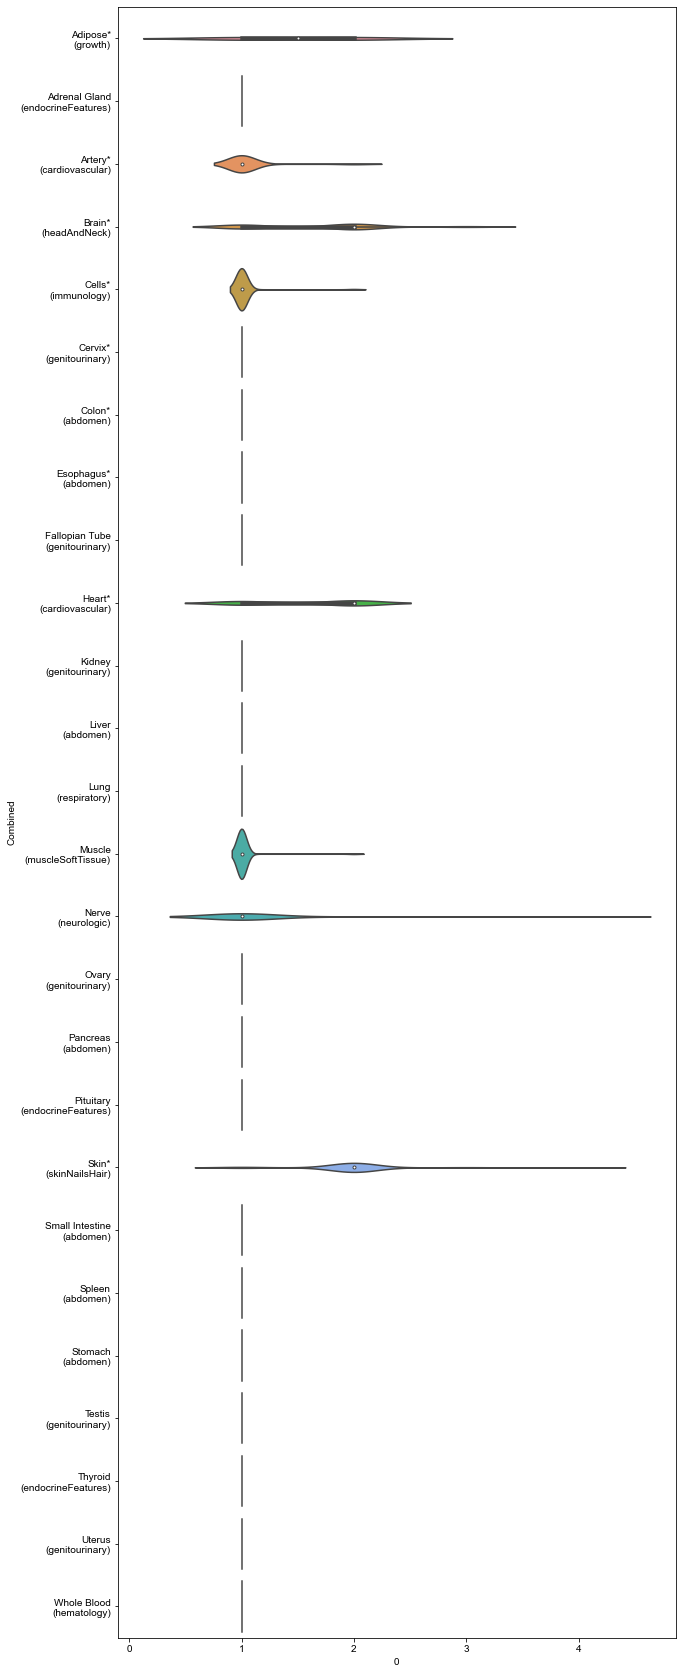

In [6]:
import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

def show_values_on_bars(axs, i=0, fontsize=15, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() / 2 + 0.1
            if i == 0:
                value = "{:.0f}".format(p.get_width())
            if i == 2:
                value = "{:.2f}".format(p.get_width())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)

            cutoff = 150
            
            if i == 3:
                value = "{:.3f}".format(p.get_height())

            if p.get_width() < cutoff:
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, )
            if p.get_width() >= cutoff:
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color='white', )

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
v_profile = pd.read_parquet('/gstock/biolo_datasets/variation/benchmark/Databases/GTEX/V7/GTEx_TPM_V_profile.parquet')
d_t = collections.Counter([e.split(' - ')[0] for e in list(v_profile.columns)[2:-2]])
new_cols = dict()
for c in d_t:
    if d_t[c] > 1:
        new_cols[c] = c + '*'
    else:
        new_cols[c] = c        

t = omim_gene_level.copy()
others = t.loc[t['Supertissue'] != 'Brain']
brain_ok = t.loc[(t['Supertissue'] == 'Brain') & (t['OMIM_body_part_gene_level'] == 'headAndNeckHead')]
t = pd.concat([others, brain_ok])

print(t.symbol.nunique())
print(t.OMIM_pheno_gene_level.nunique())



t['SuperOMIM'] = omim_gene_level['OMIM_body_part_gene_level'].map(omim_global_dict)
t = t.groupby(['Supertissue', 'SuperOMIM', 'OMIM_pheno_gene_level']).size().reset_index()
t = t.replace(new_cols)
t['Combined'] = t['Supertissue'] + '\n(' + t['SuperOMIM'] + ')'

f, ax = plt.subplots(figsize=(10,30))
v = sns.violinplot(data=t, y='Combined', x=0, ax=ax, )

# cmap = plt.cm.Oranges
# norm = matplotlib.colors.Normalize(vmin=-10, vmax=t[0].max())
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=t[0].max()+5))

# # sns.set_style('white')
# sns.set_context("paper", font_scale=1.75)

# f, ax = plt.subplots(figsize=(10,30))
# v = sns.barplot(data=t, x=0, y='Combined', ax=ax, palette=cmap(norm(t[0].values)))

# show_values_on_bars(ax)
# v.set_yticklabels(v.get_yticklabels(),  fontsize=15)
# v.set_xticklabels([])

# ax.spines['top'].set_linewidth(0)
# ax.spines['right'].set_linewidth(0)
# ax.spines['bottom'].set_linewidth(0)

# plt.xlabel("Number of associations at the gene level", labelpad=75)
# plt.ylabel("Expression tissue (phenotype body part)")
# plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
# # plt.xscale('log')

# # cbar_ax = f.add_axes([0.1, 0.06, 0.75, 0.02])
# cb = f.colorbar(sm,  orientation="horizontal", fraction=0.2, pad=0.005, )

# # plt.colorbar(v, cax=cbar_ax, orientation="horizontal")

# import matplotlib.font_manager
# print([f.name for f in matplotlib.font_manager.fontManager.ttflist])
# # cb.outline.set_linewidth(0)


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """


798
1016
Rectangle(xy=(0, -0.4), width=6, height=0.8, angle=0)
Rectangle(xy=(0, 0.6), width=10, height=0.8, angle=0)
Rectangle(xy=(0, 1.6), width=27, height=0.8, angle=0)
Rectangle(xy=(0, 2.6), width=1, height=0.8, angle=0)
Rectangle(xy=(0, 3.6), width=312, height=0.8, angle=0)
Rectangle(xy=(0, 4.6), width=778, height=0.8, angle=0)
Rectangle(xy=(0, 5.6), width=84, height=0.8, angle=0)
Rectangle(xy=(0, 6.6), width=7, height=0.8, angle=0)
Rectangle(xy=(0, 7.6), width=10, height=0.8, angle=0)
Rectangle(xy=(0, 8.6), width=8, height=0.8, angle=0)
Rectangle(xy=(0, 9.6), width=2, height=0.8, angle=0)
Rectangle(xy=(0, 10.6), width=50, height=0.8, angle=0)
Rectangle(xy=(0, 11.6), width=33, height=0.8, angle=0)
Rectangle(xy=(0, 12.6), width=34, height=0.8, angle=0)
Rectangle(xy=(0, 13.6), width=13, height=0.8, angle=0)
Rectangle(xy=(0, 14.6), width=94, height=0.8, angle=0)
Rectangle(xy=(0, 15.6), width=31, height=0.8, angle=0)
Rectangle(xy=(0, 16.6), width=12, height=0.8, angle=0)
Rectangle(xy=(

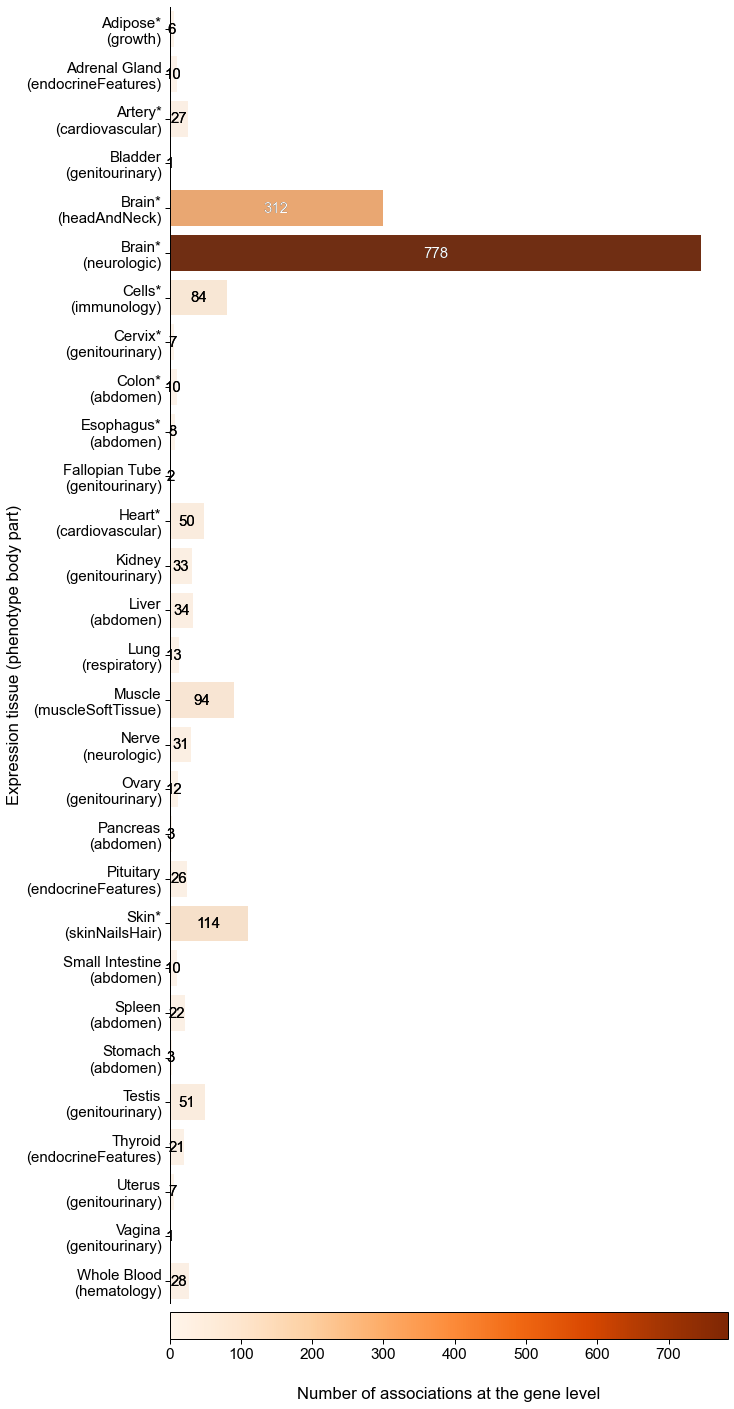

In [127]:
import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

def show_values_on_bars(axs, i=0, fontsize=15, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() / 2 + 0.1
            if i == 0:
                value = "{:.0f}".format(p.get_width())
            if i == 2:
                value = "{:.2f}".format(p.get_width())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)

            cutoff = 150
            
            if i == 3:
                value = "{:.3f}".format(p.get_height())

            if p.get_width() < cutoff:
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, )
            if p.get_width() >= cutoff:
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color='white', )

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
v_profile = pd.read_parquet('/gstock/biolo_datasets/variation/benchmark/Databases/GTEX/V7/GTEx_TPM_V_profile.parquet')
d_t = collections.Counter([e.split(' - ')[0] for e in list(v_profile.columns)[2:-2]])
new_cols = dict()
for c in d_t:
    if d_t[c] > 1:
        new_cols[c] = c + '*'
    else:
        new_cols[c] = c        

# omim_gene_level = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/matrix_omim_gene_level.xlsx')
# omim_gene_level = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/matrix_omim_gene_level_corrected.xlsx')
omim_gene_level = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/matrix_omim_gene_level_corrected_neurologic.xlsx')
omim_gene_level
        
t = omim_gene_level.copy()
others = t.loc[t['Supertissue'] != 'Brain']
brain_ok = t.loc[(t['Supertissue'] == 'Brain') & (t['OMIM_body_part_gene_level'].isin(['headAndNeckHead', 'neurologicCentralNervousSystem']))]
t = pd.concat([others, brain_ok])

print(t.symbol.nunique())
print(t.OMIM_pheno_gene_level.nunique())


t['SuperOMIM'] = omim_gene_level['OMIM_body_part_gene_level'].map(omim_global_dict)
t = t.groupby(['Supertissue', 'SuperOMIM']).size()
t = t.rename(index=new_cols)
t = t.reset_index()
t['Combined'] = t['Supertissue'] + '\n(' + t['SuperOMIM'] + ')'


from mpl_toolkits.axes_grid1.inset_locator import inset_axes


cmap = plt.cm.Oranges
norm = matplotlib.colors.Normalize(vmin=-10, vmax=t[0].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=t[0].max()+5))

# sns.set_style('white')
sns.set_context("paper", font_scale=1.75)

f, ax = plt.subplots(figsize=(10,30))
v = sns.barplot(data=t, x=0, y='Combined', ax=ax, palette=cmap(norm(t[0].values)))

show_values_on_bars(ax)
v.set_yticklabels(v.get_yticklabels(),  fontsize=15)
v.set_xticklabels([])

ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)

plt.xlabel("Number of associations at the gene level", labelpad=75)
plt.ylabel("Expression tissue (phenotype body part)")
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
# plt.xscale('log')

# cbar_ax = f.add_axes([0.1, 0.06, 0.75, 0.02])
cb = f.colorbar(sm,  orientation="horizontal", fraction=0.2, pad=0.005, )

# plt.colorbar(v, cax=cbar_ax, orientation="horizontal")

import matplotlib.font_manager
print([f.name for f in matplotlib.font_manager.fontManager.ttflist])
# cb.outline.set_linewidth(0)


Rectangle(xy=(0, -0.4), width=3, height=0.8, angle=0)
Rectangle(xy=(0, 0.6), width=3, height=0.8, angle=0)
Rectangle(xy=(0, 1.6), width=10, height=0.8, angle=0)
Rectangle(xy=(0, 2.6), width=21, height=0.8, angle=0)
Rectangle(xy=(0, 3.6), width=6, height=0.8, angle=0)
Rectangle(xy=(0, 4.6), width=1, height=0.8, angle=0)
Rectangle(xy=(0, 5.6), width=1, height=0.8, angle=0)
Rectangle(xy=(0, 6.6), width=5, height=0.8, angle=0)
Rectangle(xy=(0, 7.6), width=11, height=0.8, angle=0)
Rectangle(xy=(0, 8.6), width=5, height=0.8, angle=0)
Rectangle(xy=(0, 9.6), width=10, height=0.8, angle=0)
Rectangle(xy=(0, 10.6), width=110, height=0.8, angle=0)
Rectangle(xy=(0, 11.6), width=291, height=0.8, angle=0)
Rectangle(xy=(0, 12.6), width=87, height=0.8, angle=0)
Rectangle(xy=(0, 13.6), width=228, height=0.8, angle=0)
Rectangle(xy=(0, 14.6), width=15, height=0.8, angle=0)
Rectangle(xy=(0, 15.6), width=34, height=0.8, angle=0)
Rectangle(xy=(0, 16.6), width=35, height=0.8, angle=0)
Rectangle(xy=(0, 17.6), 

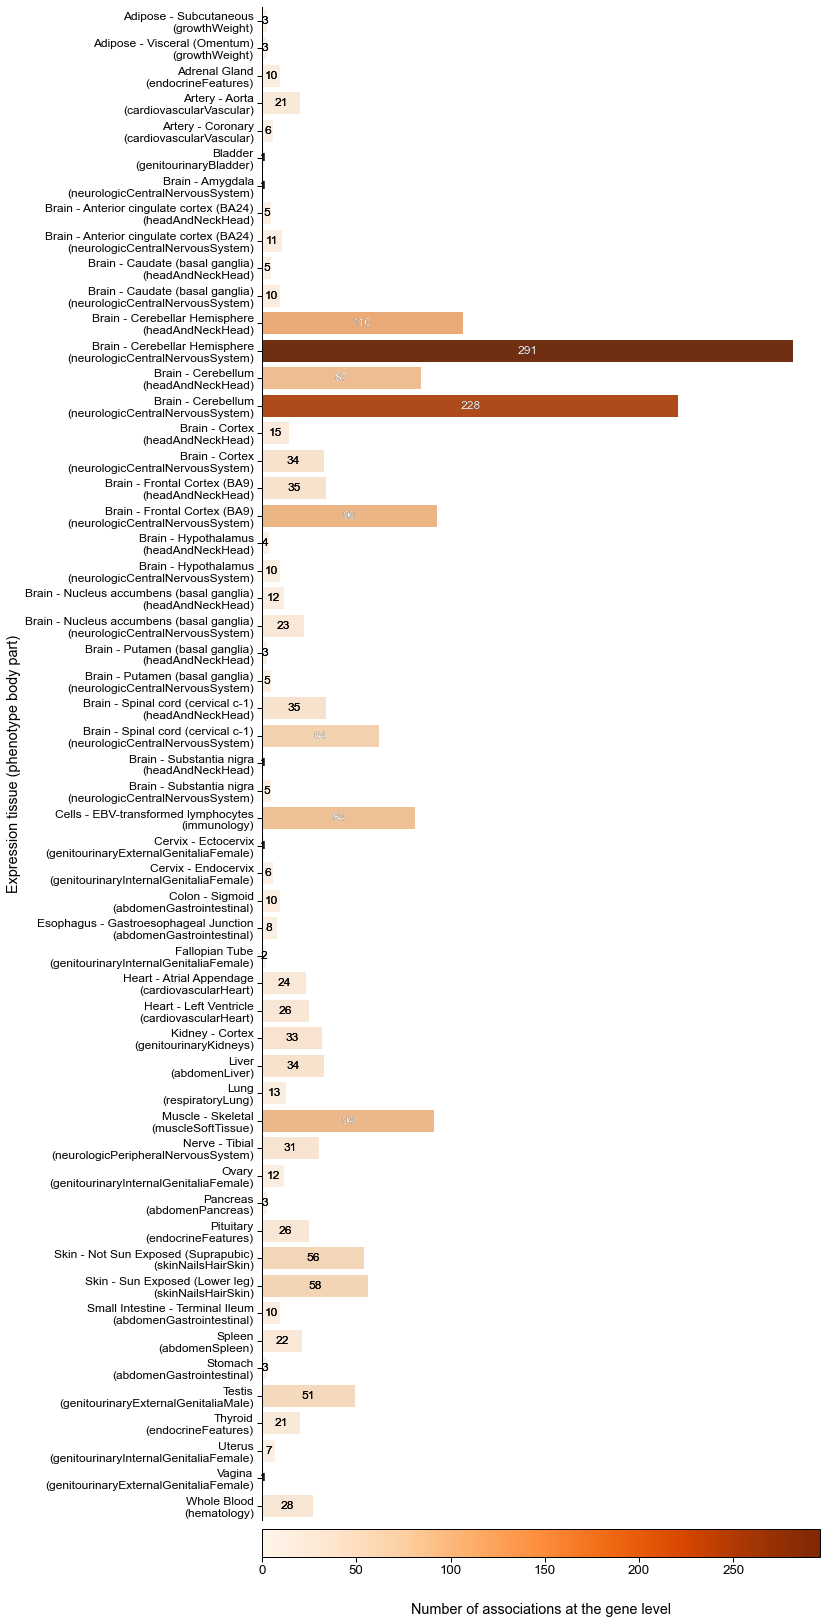

In [126]:
def show_values_on_bars(axs, i=0, fontsize=12, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() / 2 + 0.1
            if i == 0:
                value = "{:.0f}".format(p.get_width())
            if i == 2:
                value = "{:.2f}".format(p.get_width())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)

            cutoff = 60
            
            if i == 3:
                value = "{:.3f}".format(p.get_height())
            if p.get_width() < cutoff:
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)
            if p.get_width() >= cutoff:
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color='white')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        

# omim_gene_level = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/matrix_omim_gene_level.xlsx')
# omim_gene_level = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/matrix_omim_gene_level_corrected.xlsx')
omim_gene_level = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/matrix_omim_gene_level_corrected_neurologic.xlsx')
omim_gene_level
        
t = omim_gene_level.copy()
others = t.loc[t['Supertissue'] != 'Brain']
brain_ok = t.loc[(t['Supertissue'] == 'Brain') & (t['OMIM_body_part_gene_level'].isin(['headAndNeckHead', 'neurologicCentralNervousSystem']))]
t = pd.concat([others, brain_ok])

t['SuperOMIM'] = omim_gene_level['OMIM_body_part_gene_level'].map(omim_global_dict)
t = t.groupby(['Tissue_gene_level', 'OMIM_body_part_gene_level']).size().reset_index()
t['Combined'] = t['Tissue_gene_level'] + '\n(' + t['OMIM_body_part_gene_level'] + ')'
# t.groupby('Combined').sum()
# t.replace(t.groupby('Combined').sum().sort('Value', ascending=False).index[2:], 'Other').groupby('Version').sum()



from mpl_toolkits.axes_grid1.inset_locator import inset_axes


cmap = plt.cm.Oranges
norm = matplotlib.colors.Normalize(vmin=-10, vmax=t[0].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=t[0].max()+5))

# sns.set_style('white')
sns.set_context("paper", font_scale=1.5)

f, ax = plt.subplots(figsize=(10,35))
v = sns.barplot(data=t, x=0, y='Combined', ax=ax, palette=cmap(norm(t[0].values)))

show_values_on_bars(ax)
v.set_yticklabels(v.get_yticklabels(),  fontsize=12)
v.set_xticklabels([])

ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)

plt.xlabel("Number of associations at the gene level", labelpad=75)
plt.ylabel("Expression tissue (phenotype body part)")
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
# plt.xscale('log')

# cbar_ax = f.add_axes([0.1, 0.06, 0.75, 0.02])
cb = f.colorbar(sm,  orientation="horizontal", fraction=0.2, pad=0.005)

# plt.colorbar(v, cax=cbar_ax, orientation="horizontal")


# cb.outline.set_linewidth(0)


Rectangle(xy=(0, -0.4), width=149, height=0.8, angle=0)
Rectangle(xy=(0, 0.6), width=198, height=0.8, angle=0)
Rectangle(xy=(0, 1.6), width=389, height=0.8, angle=0)
Rectangle(xy=(0, 2.6), width=102, height=0.8, angle=0)
Rectangle(xy=(0, 3.6), width=2012, height=0.8, angle=0)
Rectangle(xy=(0, 4.6), width=27, height=0.8, angle=0)
Rectangle(xy=(0, 5.6), width=1892, height=0.8, angle=0)
Rectangle(xy=(0, 6.6), width=137, height=0.8, angle=0)
Rectangle(xy=(0, 7.6), width=206, height=0.8, angle=0)
Rectangle(xy=(0, 8.6), width=344, height=0.8, angle=0)
Rectangle(xy=(0, 9.6), width=51, height=0.8, angle=0)
Rectangle(xy=(0, 10.6), width=108, height=0.8, angle=0)
Rectangle(xy=(0, 11.6), width=104, height=0.8, angle=0)
Rectangle(xy=(0, 12.6), width=309, height=0.8, angle=0)
Rectangle(xy=(0, 13.6), width=205, height=0.8, angle=0)
Rectangle(xy=(0, 14.6), width=105, height=0.8, angle=0)
Rectangle(xy=(0, 15.6), width=282, height=0.8, angle=0)
Rectangle(xy=(0, 16.6), width=265, height=0.8, angle=0)
Re

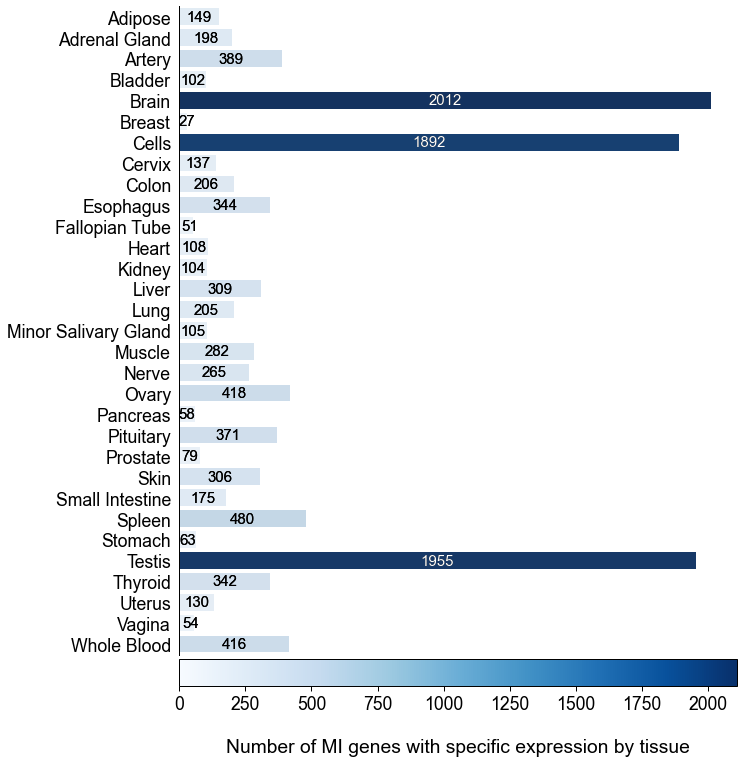

In [9]:
def show_values_on_bars(axs, i=0, fontsize=15, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            if p.get_width() < 55:
                _x = p.get_x() + p.get_width() / 2 + 15
            _y = p.get_y() + (p.get_height() / 2) + 0.2
            
            if i == 0:
                value = "{:.0f}".format(p.get_width())
            if i == 2:
                value = "{:.2f}".format(p.get_width())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)

            cutoff = 1500
            
            if i == 3:
                value = "{:.3f}".format(p.get_height())
            if p.get_width() < cutoff:
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)
            if p.get_width() >= cutoff:
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color='white')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


v_profile = pd.read_parquet('/gstock/biolo_datasets/variation/benchmark/Databases/GTEX/V7/GTEx_TPM_V_profile.parquet')
v_profile = v_profile.loc[v_profile['H_profile'] == 'Specific', ["symbol", "H_tissues", 'H_profile']]
v_profile['Supertissues'] = v_profile['H_tissues'].apply(lambda r: list(set([e.split(' - ')[0] for e in r])))




t = v_profile.explode('Supertissues')
t = t.groupby('Supertissues').size().reset_index()




cmap = plt.cm.Blues
norm = matplotlib.colors.Normalize(vmin=-100, vmax=t[0].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=t[0].max()+100))

sns.set_context("paper", font_scale=2)

f, ax = plt.subplots(figsize=(10,15))
v = sns.barplot(data=t, x=0, y='Supertissues', palette=cmap(norm(t[0].values)))
# plt.xscale('log')
plt.xlabel("Number of MI genes with specific expression by tissue", labelpad=75)
plt.ylabel('')
cb = f.colorbar(sm,  orientation="horizontal", fraction=0.2, pad=0.005)

show_values_on_bars(ax)

v.set_xticklabels([])

plt.tick_params(axis = "both", which = "both", bottom = False, top = False, left=False, right=False)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)


Rectangle(xy=(0, -0.4), width=25, height=0.8, angle=0)
Rectangle(xy=(0, 0.6), width=45, height=0.8, angle=0)
Rectangle(xy=(0, 1.6), width=67, height=0.8, angle=0)
Rectangle(xy=(0, 2.6), width=24, height=0.8, angle=0)
Rectangle(xy=(0, 3.6), width=382, height=0.8, angle=0)
Rectangle(xy=(0, 4.6), width=6, height=0.8, angle=0)
Rectangle(xy=(0, 5.6), width=362, height=0.8, angle=0)
Rectangle(xy=(0, 6.6), width=29, height=0.8, angle=0)
Rectangle(xy=(0, 7.6), width=34, height=0.8, angle=0)
Rectangle(xy=(0, 8.6), width=60, height=0.8, angle=0)
Rectangle(xy=(0, 9.6), width=6, height=0.8, angle=0)
Rectangle(xy=(0, 10.6), width=33, height=0.8, angle=0)
Rectangle(xy=(0, 11.6), width=27, height=0.8, angle=0)
Rectangle(xy=(0, 12.6), width=82, height=0.8, angle=0)
Rectangle(xy=(0, 13.6), width=34, height=0.8, angle=0)
Rectangle(xy=(0, 14.6), width=15, height=0.8, angle=0)
Rectangle(xy=(0, 15.6), width=87, height=0.8, angle=0)
Rectangle(xy=(0, 16.6), width=61, height=0.8, angle=0)
Rectangle(xy=(0, 17.

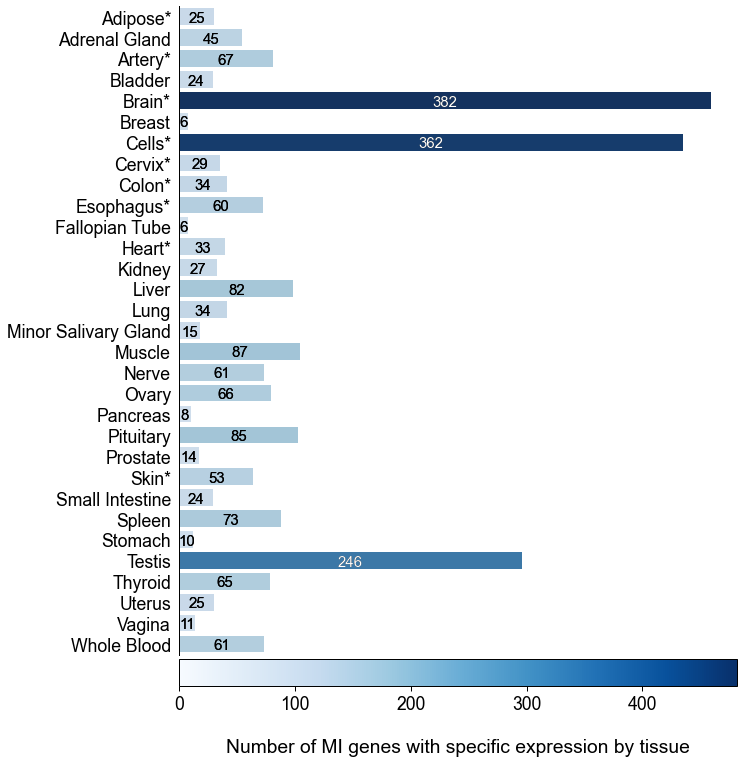

In [293]:
def show_values_on_bars(axs, i=0, fontsize=15, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
#             if p.get_width() < 55:
#                 _x = p.get_x() + p.get_width() / 2 + 15
            _y = p.get_y() + (p.get_height() / 2) + 0.25
            
            if i == 0:
                value = "{:.0f}".format(p.get_width())
            if i == 2:
                value = "{:.2f}".format(p.get_width())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)

            cutoff = 100
            
            if i == 3:
                value = "{:.3f}".format(p.get_height())
            if p.get_width() < cutoff:
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)
            if p.get_width() >= cutoff:
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color='white')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


        
v_profile = pd.read_parquet('/gstock/biolo_datasets/variation/benchmark/Databases/GTEX/V7/GTEx_TPM_V_profile.parquet')
d_t = collections.Counter([e.split(' - ')[0] for e in list(v_profile.columns)[2:-2]])
new_cols = dict()
for c in d_t:
    if d_t[c] > 1:
        new_cols[c] = c + '*'
    else:
        new_cols[c] = c


v_profile = pd.read_parquet('/gstock/EXOTIC/data/EXPRESSION/GTEX_specific_in_OMIM.parquet')
v_profile = v_profile.loc[v_profile['H_profile'] == 'Specific', ["symbol", "H_tissues", 'H_profile']]
v_profile['Supertissues'] = v_profile['H_tissues'].apply(lambda r: list(set([e.split(' - ')[0] for e in r])))
t = v_profile.explode('Supertissues')
t = t.groupby('Supertissues').size()
t = t.rename(index=new_cols)
t = t.reset_index()



cmap = plt.cm.Blues
norm = matplotlib.colors.Normalize(vmin=-100, vmax=t[0].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=t[0].max()+100))

sns.set_context("paper", font_scale=2)

f, ax = plt.subplots(figsize=(10,15))
v = sns.barplot(data=t, x=0, y='Supertissues', palette=cmap(norm(t[0].values)))
# plt.xscale('log')
plt.xlabel("Number of MI genes with specific expression by tissue", labelpad=75)
plt.ylabel('')
cb = f.colorbar(sm,  orientation="horizontal", fraction=0.2, pad=0.005)

show_values_on_bars(ax)

v.set_xticklabels([])

plt.tick_params(axis = "both", which = "both", bottom = False, top = False, left=False, right=False)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)


Rectangle(xy=(0, -0.4), width=115, height=0.8, angle=0)
Rectangle(xy=(0, 0.6), width=78, height=0.8, angle=0)
Rectangle(xy=(0, 1.6), width=198, height=0.8, angle=0)
Rectangle(xy=(0, 2.6), width=235, height=0.8, angle=0)
Rectangle(xy=(0, 3.6), width=64, height=0.8, angle=0)
Rectangle(xy=(0, 4.6), width=217, height=0.8, angle=0)
Rectangle(xy=(0, 5.6), width=102, height=0.8, angle=0)
Rectangle(xy=(0, 6.6), width=13, height=0.8, angle=0)
Rectangle(xy=(0, 7.6), width=35, height=0.8, angle=0)
Rectangle(xy=(0, 8.6), width=55, height=0.8, angle=0)
Rectangle(xy=(0, 9.6), width=1196, height=0.8, angle=0)
Rectangle(xy=(0, 10.6), width=921, height=0.8, angle=0)
Rectangle(xy=(0, 11.6), width=163, height=0.8, angle=0)
Rectangle(xy=(0, 12.6), width=389, height=0.8, angle=0)
Rectangle(xy=(0, 13.6), width=5, height=0.8, angle=0)
Rectangle(xy=(0, 14.6), width=61, height=0.8, angle=0)
Rectangle(xy=(0, 15.6), width=127, height=0.8, angle=0)
Rectangle(xy=(0, 16.6), width=19, height=0.8, angle=0)
Rectangle(

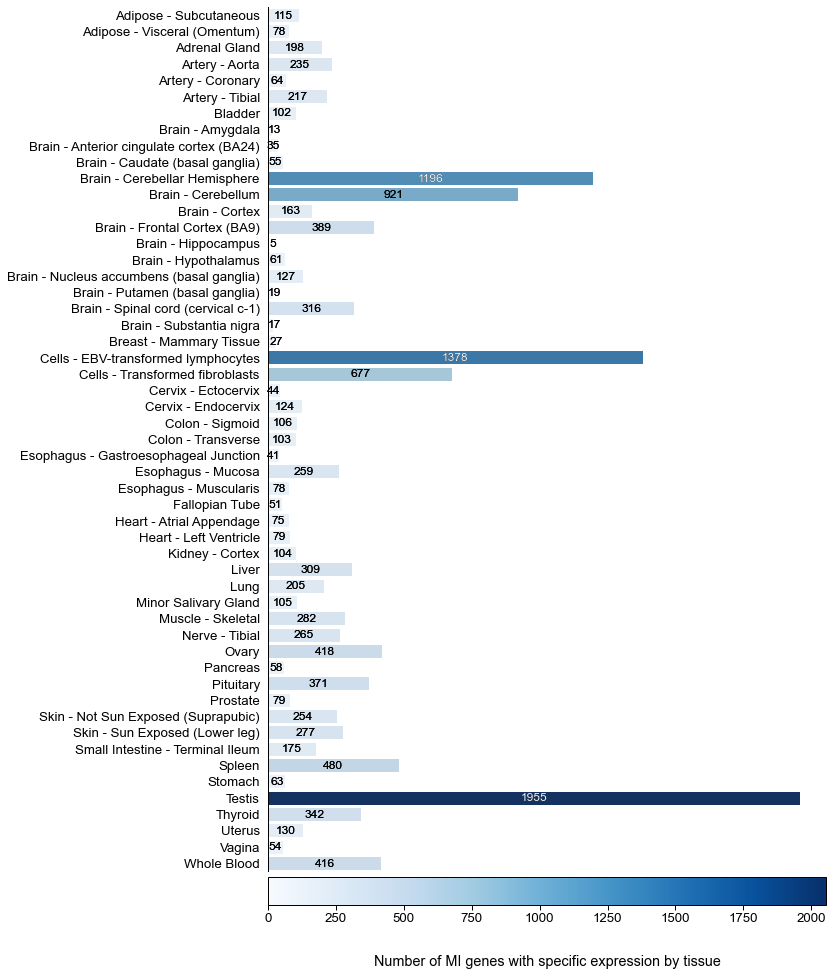

In [274]:
def show_values_on_bars(axs, i=0, fontsize=12, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            if p.get_width() < 35:
                _x = p.get_x() + p.get_width() / 2 + 15
            _y = p.get_y() + p.get_height() / 2 + 0.2
            if i == 0:
                value = "{:.0f}".format(p.get_width())
            if i == 2:
                value = "{:.2f}".format(p.get_width())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)

            cutoff = 1000
            
            if i == 3:
                value = "{:.3f}".format(p.get_height())
            if p.get_width() < cutoff:
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)
            if p.get_width() >= cutoff:
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color='white')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


v_profile = pd.read_parquet('/gstock/biolo_datasets/variation/benchmark/Databases/GTEX/V7/GTEx_TPM_V_profile.parquet')


v_profile = v_profile.loc[v_profile['H_profile'] == 'Specific', ["symbol", "H_tissues", 'H_profile']]
v_profile['Supertissues'] = v_profile['H_tissues'].apply(lambda r: list(set([e.split(' - ')[0] for e in r])))




t = v_profile.explode('H_tissues')
t = t.groupby('H_tissues').size().reset_index()




cmap = plt.cm.Blues
norm = matplotlib.colors.Normalize(vmin=-100, vmax=t[0].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=t[0].max()+100))

sns.set_context("paper", font_scale=1.5)

f, ax = plt.subplots(figsize=(10,20))
v = sns.barplot(data=t, x=0, y='H_tissues', palette=cmap(norm(t[0].values)))
# plt.xscale('log')
plt.xlabel("Number of MI genes with specific expression by tissue", labelpad=75)
plt.ylabel('')
cb = f.colorbar(sm,  orientation="horizontal", fraction=0.2, pad=0.005)

show_values_on_bars(ax)

v.set_xticklabels([])

plt.tick_params(axis = "both", which = "both", bottom = False, top = False, left=False, right=False)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)


Rectangle(xy=(0, -0.4), width=22, height=0.8, angle=0)
Rectangle(xy=(0, 0.6), width=15, height=0.8, angle=0)
Rectangle(xy=(0, 1.6), width=45, height=0.8, angle=0)
Rectangle(xy=(0, 2.6), width=39, height=0.8, angle=0)
Rectangle(xy=(0, 3.6), width=9, height=0.8, angle=0)
Rectangle(xy=(0, 4.6), width=45, height=0.8, angle=0)
Rectangle(xy=(0, 5.6), width=24, height=0.8, angle=0)
Rectangle(xy=(0, 6.6), width=2, height=0.8, angle=0)
Rectangle(xy=(0, 7.6), width=8, height=0.8, angle=0)
Rectangle(xy=(0, 8.6), width=10, height=0.8, angle=0)
Rectangle(xy=(0, 9.6), width=227, height=0.8, angle=0)
Rectangle(xy=(0, 10.6), width=178, height=0.8, angle=0)
Rectangle(xy=(0, 11.6), width=27, height=0.8, angle=0)
Rectangle(xy=(0, 12.6), width=78, height=0.8, angle=0)
Rectangle(xy=(0, 13.6), width=1, height=0.8, angle=0)
Rectangle(xy=(0, 14.6), width=11, height=0.8, angle=0)
Rectangle(xy=(0, 15.6), width=22, height=0.8, angle=0)
Rectangle(xy=(0, 16.6), width=5, height=0.8, angle=0)
Rectangle(xy=(0, 17.6),

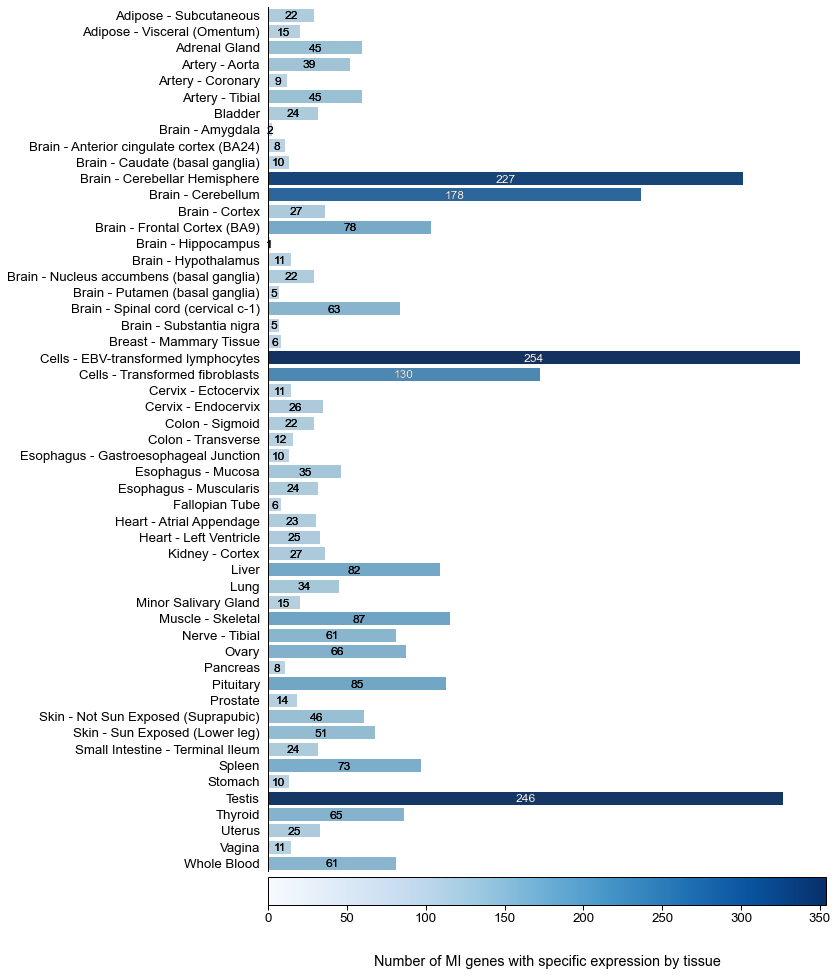

In [269]:
def show_values_on_bars(axs, i=0, fontsize=12, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
#             if p.get_width() < 35:
#                 _x = p.get_x() + p.get_width() / 2 + 15
            _y = p.get_y() + p.get_height() / 2 + 0.25
            if i == 0:
                value = "{:.0f}".format(p.get_width())
            if i == 2:
                value = "{:.2f}".format(p.get_width())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)

            cutoff = 100
            
            if i == 3:
                value = "{:.3f}".format(p.get_height())
            if p.get_width() < cutoff:
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)
            if p.get_width() >= cutoff:
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color='white')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


v_profile = pd.read_parquet('/gstock/EXOTIC/data/EXPRESSION/GTEX_specific_in_OMIM.parquet')
v_profile = v_profile.loc[v_profile['H_profile'] == 'Specific', ["symbol", "H_tissues", 'H_profile']]
v_profile['Supertissues'] = v_profile['H_tissues'].apply(lambda r: list(set([e.split(' - ')[0] for e in r])))




t = v_profile.explode('H_tissues')
t = t.groupby('H_tissues').size().reset_index()




cmap = plt.cm.Blues
norm = matplotlib.colors.Normalize(vmin=-100, vmax=t[0].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=t[0].max()+100))

sns.set_context("paper", font_scale=1.5)

f, ax = plt.subplots(figsize=(10,20))
v = sns.barplot(data=t, x=0, y='H_tissues', palette=cmap(norm(t[0].values)))
# plt.xscale('log')
plt.xlabel("Number of MI genes with specific expression by tissue", labelpad=75)
plt.ylabel('')
cb = f.colorbar(sm,  orientation="horizontal", fraction=0.2, pad=0.005)

show_values_on_bars(ax)

v.set_xticklabels([])

plt.tick_params(axis = "both", which = "both", bottom = False, top = False, left=False, right=False)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)


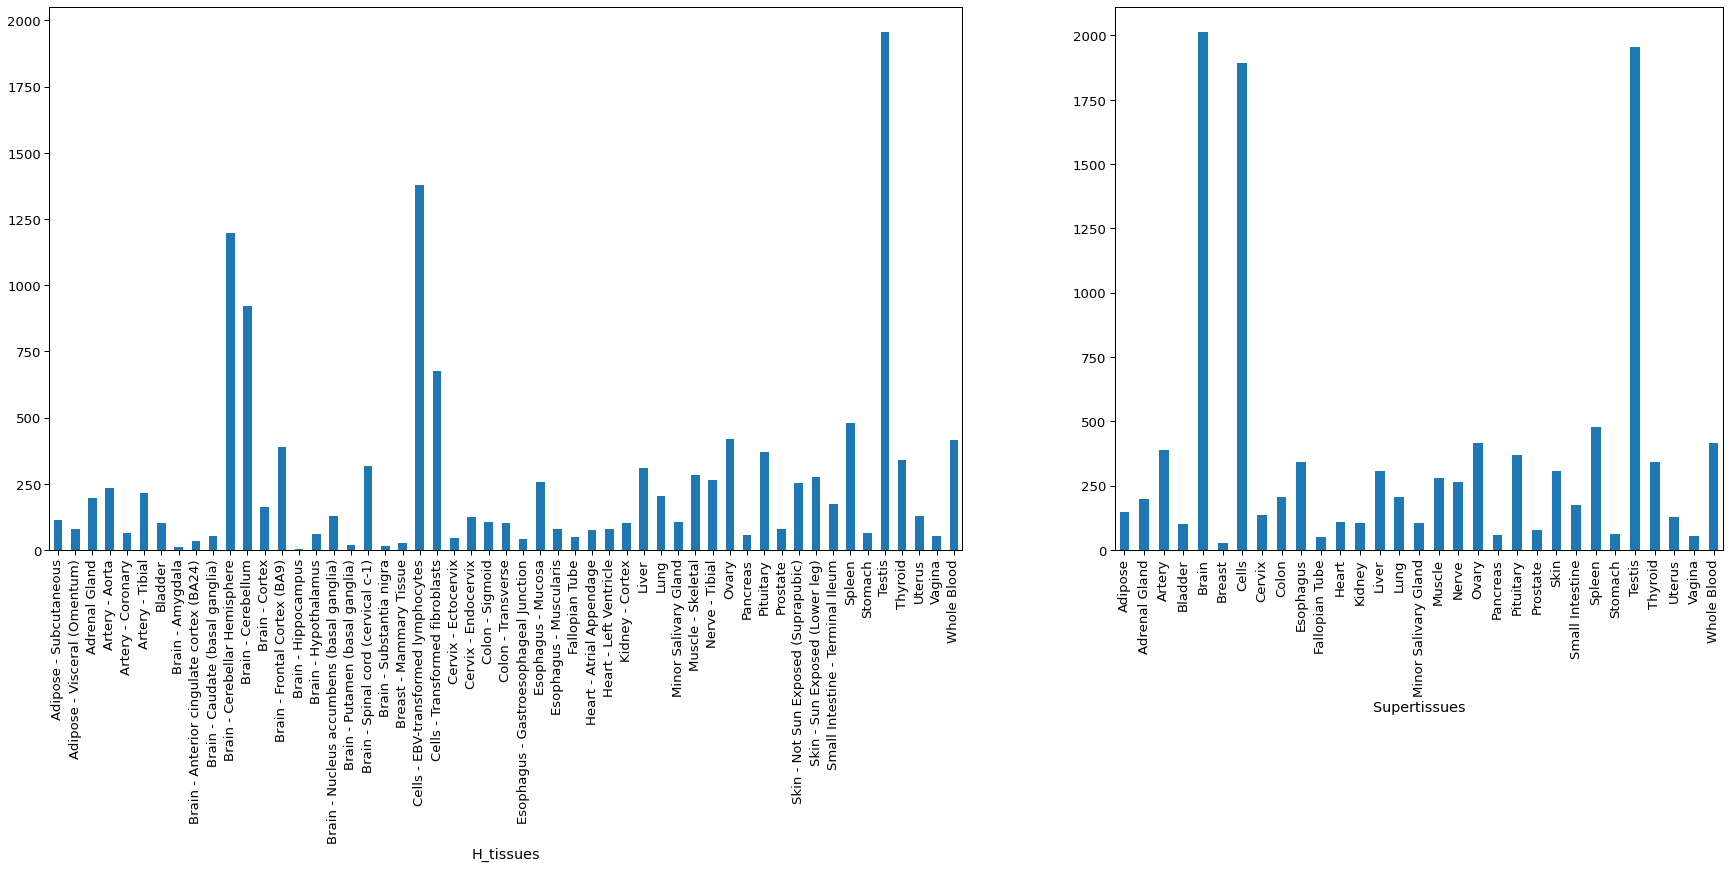

In [159]:
from matplotlib import gridspec


v_profile = pd.read_parquet('/gstock/biolo_datasets/variation/benchmark/Databases/GTEX/V7/GTEx_TPM_V_profile.parquet')
v_profile = v_profile.loc[v_profile['H_profile'] == 'Specific', ["symbol", "H_tissues", 'H_profile']]
v_profile['Supertissues'] = v_profile['H_tissues'].apply(lambda r: list(set([e.split(' - ')[0] for e in r])))

f, ax = plt.subplots(figsize=(30,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1]) 

t = v_profile.explode('Supertissues')
ax1 = plt.subplot(gs[1])
t.groupby('Supertissues').size().plot.bar(ax=ax1)

t = v_profile.explode('H_tissues')
ax0 = plt.subplot(gs[0])
t.groupby('H_tissues').size().plot.bar(ax=ax0)

In [7]:
exon_level  = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/table_OMIM_gene_exon_level_matrix.xlsx')
test = list(exon_level.filter(regex='exotic').columns)
exon_level = exon_level[[c for c in exon_level.columns if c not in test]]
exon_level = exon_level.loc[~exon_level['OMIM_details_exon_level'].str.contains('Sinusitis')]
exon_level


,MAP,Ratio_num,mRNA_nb,symbol,mean_proportion,Max,Tissues_Max,Tissues_Max_organs,pext_max,tissues_OK_bronze,...,Supertissue,OMIM_body_part_gene_level,OMIM_details_gene_level,Corrected_Tissues_y,H_tissues_y,OMIM_pheno_exon_level,OMIM_pheno_name_exon_level,Tissue_exon_level,OMIM_body_part_exon_level,OMIM_details_exon_level
0,ADA_43251648-43251719,0.666667,3,ADA,0.64261,0.942592,['Cells - EBV-transformed lymphocytes'],['Cells'],0.86663,['Cells - EBV-transformed lymphocytes' 'Whole ...,...,Cells,immunology,"['Frequent fungal, viral, and opportunistic in...",['Whole Blood'],['Cells - EBV-transformed lymphocytes'],102700,Severe combined immunodeficiency due to ADA de...,Whole Blood,hematology,"['Autoimmune hemolytic anemia', 'Idiopathic th..."
1,AK2_33476430-33476434,0.500000,8,AK2,0.24461,0.981949,['Whole Blood'],['Whole Blood'],0.54142,[],...,Cells,immunology,"['Lymphoid hypoplasia', 'Thymic hypoplasia', '...",['Whole Blood'],['Cells - EBV-transformed lymphocytes'],267500,Reticular dysgenesis,Whole Blood,hematology,"['Congenital agranulocytosis', 'Leukopenia', '..."
2,ANTXR2_80828583-80828621,0.750000,4,ANTXR2,0.24885,0.949373,['Whole Blood'],['Whole Blood'],0.33333,['Cells - Cultured fibroblasts' 'Cells - EBV-t...,...,Esophagus,abdomenGastrointestinal,['Diarrhea (in severe cases)'],['Cells - EBV-transformed lymphocytes' 'Whole ...,['Esophagus - Gastroesophageal Junction' 'Esop...,228600,Hyaline fibromatosis syndrome,Cells - EBV-transformed lymphocytes,immunology,['Recurrent infections (in severe cases)']
3,ANTXR2_80990654-80990661,0.500000,4,ANTXR2,0.26683,0.983724,['Whole Blood'],['Whole Blood'],0.41441,[],...,Esophagus,abdomenGastrointestinal,['Diarrhea (in severe cases)'],['Cells - EBV-transformed lymphocytes' 'Whole ...,['Esophagus - Gastroesophageal Junction' 'Esop...,228600,Hyaline fibromatosis syndrome,Cells - EBV-transformed lymphocytes,immunology,['Recurrent infections (in severe cases)']
4,ANTXR2_80992737-80992808,0.500000,4,ANTXR2,0.26683,0.983724,['Whole Blood'],['Whole Blood'],0.41441,[],...,Esophagus,abdomenGastrointestinal,['Diarrhea (in severe cases)'],['Cells - EBV-transformed lymphocytes' 'Whole ...,['Esophagus - Gastroesophageal Junction' 'Esop...,228600,Hyaline fibromatosis syndrome,Cells - EBV-transformed lymphocytes,immunology,['Recurrent infections (in severe cases)']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,TRIP12_230723635-230724290,0.961538,26,TRIP12,0.51975,0.963544,['Brain - Cerebellar Hemisphere'],['Brain'],0.77236,[],...,Testis,genitourinaryExternalGenitaliaMale,['Macroorchidism'],['Brain - Cerebellar Hemisphere'],['Testis'],617752,"Mental retardation, autosomal dominant 49",Brain - Cerebellar Hemisphere,headAndNeckHead,['Macrocephaly']
248,VPS33B_91557629-91557663,0.666667,3,VPS33B,0.46984,0.927890,['Cells - EBV-transformed lymphocytes'],['Cells'],0.70367,['Cells - Cultured fibroblasts' 'Cells - EBV-t...,...,Brain,headAndNeckHead,['Microcephaly'],['Cells - EBV-transformed lymphocytes' 'Muscle...,['Brain - Cerebellar Hemisphere'],208085,"Arthrogryposis, renal dysfunction, and cholest...",Cells - EBV-transformed lymphocytes,immunology,"['Recurrent febrile illnesses', 'B and T cell ..."
249,VPS33B_91560193-91560254,0.666667,3,VPS33B,0.46984,0.927890,['Cells - EBV-transformed lymphocytes'],['Cells'],0.70367,['Cells - Cultured fibroblasts' 'Cells - EBV-t...,...,Brain,headAndNeckHead,['Microcephaly'],['Cells - EBV-transformed lymphocytes' 'Muscle...,['Brain - Cerebellar Hemisphere'],208085,"Arthrogryposis, renal dysfunction, and cholest...",Cells - EBV-transformed lymphocytes,immunology,"['Recurrent febrile illnesses', 'B and T cell ..."
250,VPS33B_91561035-91561115,0.333333,3,VPS33B,0.34367,0.959377,['Cells - EBV-transformed lymphocytes'],['Cells'],0.68010,['Cells - Cultured fibroblasts'],...,Brain,headAndNeckHead,['Microcephaly'],['Cells - Cultured fibroblasts' 'Cells - EBV-t...,['Brain - Cerebellar Hemisphere'],208085,"Arthrogryposis, renal dysfunction

In [38]:
t = exon_level.copy()
print(t.symbol.nunique())
print(t.MAP.nunique())

42
157


In [42]:
t = exon_level.copy()
t = t[['Supertissue', 'Tissue_exon_level', 'symbol', 'MAP']]
t['Supertissue_exon'] = t['Tissue_exon_level'].apply(lambda r: r.split(' - ')[0])
t.loc[(t['Supertissue'].isin(['Brain', 'Testis'])) & (t['Supertissue_exon'] == 'Muscle'), 'symbol'].unique()

array(['AP4B1', 'BPTF', 'CAMK2B', 'DNM1L', 'KIF21A', 'MKS1', 'PNPLA6',
       'PRMT7', 'SLC25A46', 'TRIP12'], dtype=object)

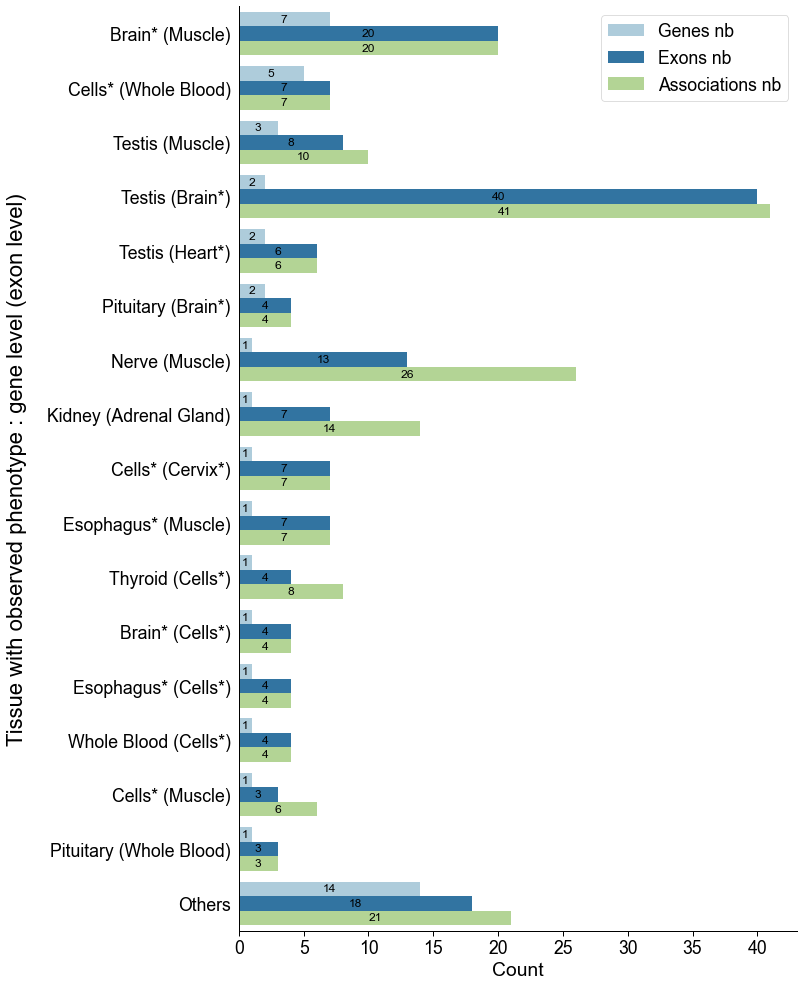

In [120]:
def show_values_on_bars(axs, i=0, fontsize=12, rotation=0):
    def _show_on_single_plot(ax):
        for j, p in enumerate(ax.patches):
            _x = p.get_x() + p.get_width() / 2
#             if p.get_width() < 35:
#                 _x = p.get_x() + p.get_width() / 2 + 15
            _y = p.get_y() + p.get_height() / 2 +0.05
            if i == 0:
                value = "{:.0f}".format(p.get_width())
            if i == 2:
                value = "{:.2f}".format(p.get_width())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)

#             cutoff = 100
            
#             if i == 3:
#                 value = "{:.3f}".format(p.get_height())
#             if p.get_width() < cutoff:
#                 ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)
#             if 29 <= j <= 57:
#                 ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color='white', weight='bold')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
v_profile = pd.read_parquet('/gstock/biolo_datasets/variation/benchmark/Databases/GTEX/V7/GTEx_TPM_V_profile.parquet')
d_t = collections.Counter([e.split(' - ')[0] for e in list(v_profile.columns)[2:-2]])
new_cols = dict()
for c in d_t:
    if d_t[c] > 1:
        new_cols[c] = c + '*'
    else:
        new_cols[c] = c        

sns.set_context("paper", font_scale=2)

exon_level  = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/table_OMIM_gene_exon_level_matrix.xlsx')
test = list(exon_level.filter(regex='exotic').columns)
exon_level = exon_level[[c for c in exon_level.columns if c not in test]]
exon_level = exon_level.loc[~exon_level['OMIM_details_exon_level'].str.contains('Sinusitis')]
exon_level


f, ax = plt.subplots(figsize=(10,17))

t = exon_level.copy()
t = t[['Supertissue', 'Tissue_exon_level', 'symbol', 'MAP']]
t['Supertissue_exon'] = t['Tissue_exon_level'].apply(lambda r: r.split(' - ')[0])
t = t.replace(new_cols)
t2 = t.groupby(['Supertissue', 'Supertissue_exon']).size()
t = t.groupby(['Supertissue', 'Supertissue_exon']).nunique().drop(['Supertissue', 'Supertissue_exon', 'Tissue_exon_level'], axis=1)
t = pd.concat([t, t2], axis=1).reset_index()
t = t.sort_values(by=['symbol', 'MAP', 0], ascending=False)
t

cutoff = 2

t['Merge_index'] = t[t.columns[0]] + ' (' + t[t.columns[1]] + ')'
t = t.rename({0 : 'Associations nb', 'symbol' : 'Genes nb', 'MAP' : 'Exons nb'}, axis=1)
t_others = t.loc[t['Exons nb'] <= cutoff].sum()
t_others['Merge_index'] = 'Others'
t = pd.concat([t.loc[t['Exons nb'] > cutoff], pd.DataFrame(t_others).T])
t = t.melt(id_vars='Merge_index', value_vars=['Genes nb', 'Exons nb', 'Associations nb'])
sns.barplot(data=t, y='Merge_index', x='value', ax=ax, palette='Paired', hue='variable')
show_values_on_bars(ax)
plt.ylabel('Tissue with observed phenotype : gene level (exon level)', fontsize=22, labelpad=20)
plt.xlabel('Count')
legend = ax.get_legend()
legend.set_title('')
plt.tick_params(axis = "y", which = "both", bottom = False, top = False, left=False, right=False)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
# ax.spines['bottom'].set_linewidth(0)


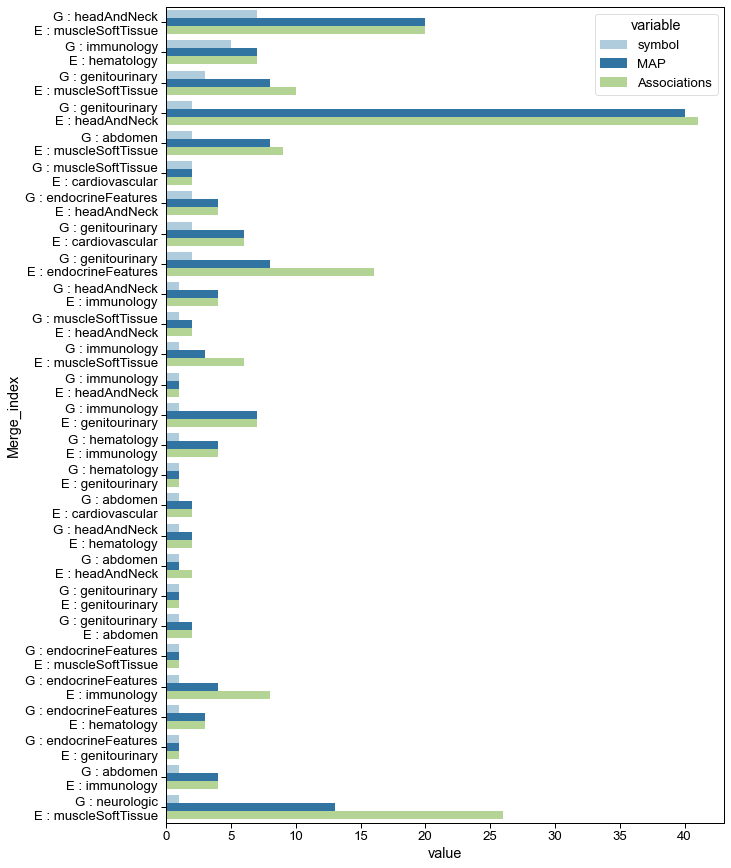

In [400]:
f, ax = plt.subplots(figsize=(10,15))
# t = exon_level.copy()
# t = t[['OMIM_body_part_gene_level', 'OMIM_body_part_exon_level']].replace(omim_global_dict)
# t = t.groupby(['OMIM_body_part_gene_level', 'OMIM_body_part_exon_level']).size().reset_index()
# t['Merge_index'] = 'G : ' +  t[t.columns[0]] + '\n' + 'E : ' + t[t.columns[1]]
# sns.barplot(data=t, y='Merge_index', x=0, ax=ax, palette='Paired')


t = exon_level.copy()
t = t.replace(new_cols)
t = t[['OMIM_body_part_gene_level', 'OMIM_body_part_exon_level', 'symbol', 'MAP']]
t = t.replace(omim_global_dict)

# t['Supertissue_exon'] = t['Tissue_exon_level'].apply(lambda r: r.split(' - ')[0])
t2 = t.groupby(['OMIM_body_part_gene_level', 'OMIM_body_part_exon_level']).size()
t = t.groupby(['OMIM_body_part_gene_level', 'OMIM_body_part_exon_level']).nunique().drop(['OMIM_body_part_gene_level', 'OMIM_body_part_exon_level'], axis=1)
t = pd.concat([t, t2], axis=1).reset_index()
t = t.sort_values(by='symbol', ascending=False)
t['Merge_index'] = 'G : ' +  t[t.columns[0]] + '\n' + 'E : ' + t[t.columns[1]]
t = t.rename({0 : 'Associations'}, axis=1)
t = t.melt(id_vars='Merge_index', value_vars=['symbol', 'MAP', 'Associations'])
sns.barplot(data=t, y='Merge_index', x='value', ax=ax, palette='Paired', hue='variable')

In [ ]:
t = exon_level[['Supertissue', 'Tissue_exon_level']]
t['Supertissue_exon'] = t['Tissue_exon_level'].apply(lambda r: r.split(' - ')[0])
t.groupby(['Supertissue', 'Supertissue_exon']).size().plot.bar(orientation='vertical')

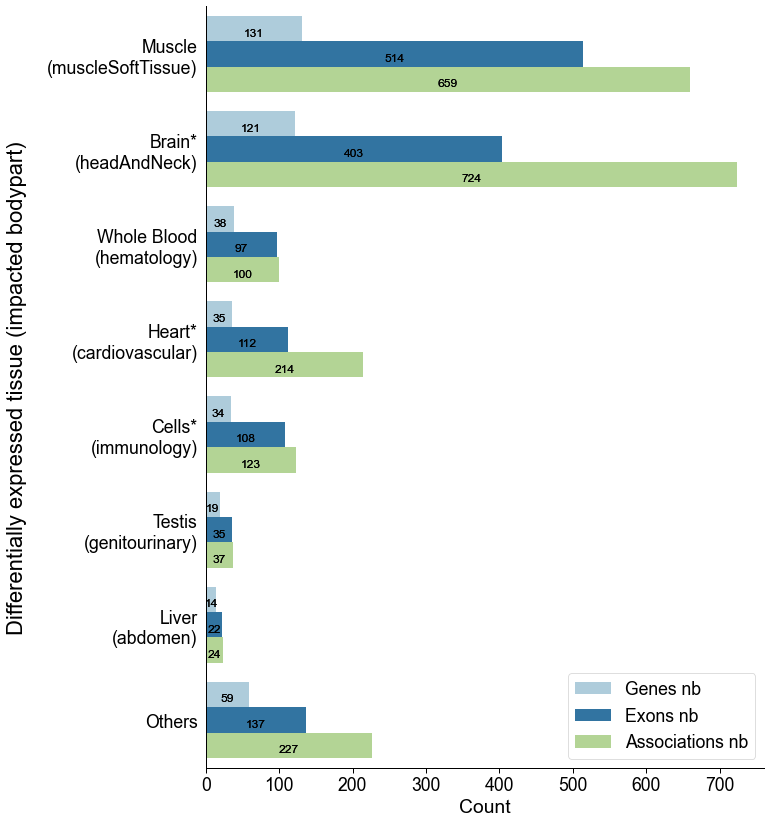

In [7]:
def show_values_on_bars(axs, i=0, fontsize=12, rotation=0):
    def _show_on_single_plot(ax):
        for j, p in enumerate(ax.patches):
            _x = p.get_x() + p.get_width() / 2
#             if p.get_width() < 35:
#                 _x = p.get_x() + p.get_width() / 2 + 15
            _y = p.get_y() + p.get_height() / 2 + 0.075
            if i == 0:
                value = "{:.0f}".format(p.get_width())
            if i == 2:
                value = "{:.2f}".format(p.get_width())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)

            cutoff = 100
            
            if i == 3:
                value = "{:.3f}".format(p.get_height())
#             if p.get_width() < cutoff:
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)
#             if 29 <= j <= 57:
#                 ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color='white', weight='bold')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
        
v_profile = pd.read_parquet('/gstock/biolo_datasets/variation/benchmark/Databases/GTEX/V7/GTEx_TPM_V_profile.parquet')
d_t = collections.Counter([e.split(' - ')[0] for e in list(v_profile.columns)[2:-2]])
new_cols = dict()
for c in d_t:
    if d_t[c] > 1:
        new_cols[c] = c + '*'
    else:
        new_cols[c] = c        

        
        
exon_level  = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/table_OMIM_exon_level_matrix_corrected.xlsx')        
# exon_level  = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/table_OMIM_exon_level_matrix_corrected_neurologic.xlsx')
test = list(exon_level.filter(regex='exotic').columns)
exon_level = exon_level[[c for c in exon_level.columns if c not in test]]
# exon_level = exon_level.loc[~exon_level['OMIM_details_exon_level'].str.contains('Sinusitis')]
exon_level

        
sns.set_context("paper", font_scale=2)

        
f, ax = plt.subplots(figsize=(10,14))

t = exon_level.copy()
t = t[['OMIM_body_part_exon_level', 'Tissue_exon_level', 'symbol', 'MAP']]
t['Supertissue_exon'] = t['Tissue_exon_level'].apply(lambda r: r.split(' - ')[0])
t = t.replace(new_cols)
t = t.replace(omim_global_dict)

t2 = t.groupby(['Supertissue_exon', 'OMIM_body_part_exon_level']).size()
t = t.groupby(['Supertissue_exon', 'OMIM_body_part_exon_level']).nunique().drop(['OMIM_body_part_exon_level', 'Supertissue_exon', 'Tissue_exon_level'], axis=1)
t = pd.concat([t, t2], axis=1).reset_index()
t = t.sort_values(by=['symbol', 'MAP', 0], ascending=False)
t

cutoff = 11

t['Merge_index'] = t[t.columns[0]] + '\n(' + t[t.columns[1]] + ')'
t = t.rename({0 : 'Associations nb', 'symbol' : 'Genes nb', 'MAP' : 'Exons nb'}, axis=1)
t_others = t.loc[t['Genes nb'] < cutoff].sum()
t_others['Merge_index'] = 'Others'
t = pd.concat([t.loc[t['Genes nb'] >= cutoff], pd.DataFrame(t_others).T])
t

t = t.melt(id_vars='Merge_index', value_vars=['Genes nb', 'Exons nb', 'Associations nb'])


sns.barplot(data=t, y='Merge_index', x='value', ax=ax, palette='Paired', hue='variable')
show_values_on_bars(ax)
plt.ylabel('Differentially expressed tissue (impacted bodypart)', fontsize=22, labelpad=20)
plt.xlabel('Count')
legend = ax.get_legend()
legend.set_title('')
plt.tick_params(axis = "y", which = "both", bottom = False, top = False, left=False, right=False)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

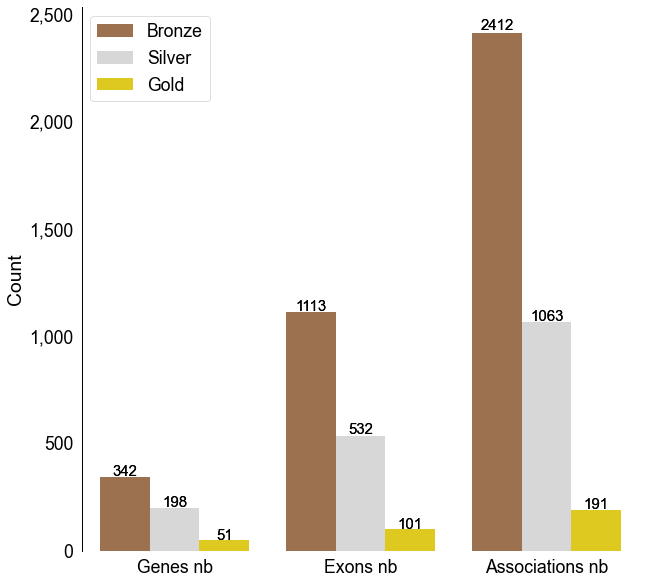

In [8]:
def show_values_on_bars(axs, i=0, fontsize=15, rotation=0):
    def _show_on_single_plot(ax):
        for j, p in enumerate(ax.patches):
            _x = p.get_x() + p.get_width() / 2
#             if p.get_width() < 35:
#                 _x = p.get_x() + p.get_width() / 2 + 15
            _y = p.get_y() + p.get_height() * 1.025

            if p.get_height() > 600:
                _y = p.get_y() + p.get_height() * 1.005
        
    
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)

            cutoff = 100
            
            if i == 3:
                value = "{:.3f}".format(p.get_height())
#             if p.get_width() < cutoff:
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)
#             if 29 <= j <= 57:
#                 ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color='white', weight='bold')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
        
v_profile = pd.read_parquet('/gstock/biolo_datasets/variation/benchmark/Databases/GTEX/V7/GTEx_TPM_V_profile.parquet')
d_t = collections.Counter([e.split(' - ')[0] for e in list(v_profile.columns)[2:-2]])
new_cols = dict()
for c in d_t:
    if d_t[c] > 1:
        new_cols[c] = c + '*'
    else:
        new_cols[c] = c        

        
        
        
exon_level  = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/table_OMIM_exon_level_matrix_corrected_neurologic.xlsx')
test = list(exon_level.filter(regex='exotic').columns)
exon_level = exon_level[[c for c in exon_level.columns if c not in test]]
# exon_level = exon_level.loc[~exon_level['OMIM_details_exon_level'].str.contains('Sinusitis')]
exon_level

        
sns.set_context("paper", font_scale=2)

        
f, ax = plt.subplots(figsize=(10,10))

t = exon_level.copy()
t['Threshold'] = t['Threshold'].str.title()
t = t[['OMIM_body_part_exon_level', 'Tissue_exon_level', 'symbol', 'MAP', 'Threshold']]
t['Supertissue_exon'] = t['Tissue_exon_level'].apply(lambda r: r.split(' - ')[0])
t = t.replace(new_cols)
t = t.replace(omim_global_dict)

t2 = t.groupby(['Threshold']).size()
t = t.groupby(['Threshold']).nunique().drop(['OMIM_body_part_exon_level', 'Supertissue_exon', 'Tissue_exon_level', 'Threshold'], axis=1)
t = pd.concat([t, t2], axis=1).reset_index()
t = t.sort_values(by=['symbol', 'MAP', 0], ascending=False)
t


# t['Merge_index'] = t[t.columns[0]] + ' (' + t[t.columns[1]] + ')'
t = t.rename({0 : 'Associations nb', 'symbol' : 'Genes nb', 'MAP' : 'Exons nb'}, axis=1)
t = t.melt(id_vars=['Threshold'], value_vars=['Genes nb', 'Exons nb', 'Associations nb'])
t

sns.barplot(data=t, x='variable', y='value', ax=ax,  hue='Threshold', palette={'Bronze' : "#A77044", 'Silver' : "#D7D7D7", 'Gold': "#FEE101"})
show_values_on_bars(ax)
plt.ylabel('Count')
plt.xlabel('')
legend = ax.get_legend()
legend.set_title('')
# plt.yscale('log')
# plt.ylim(1,10000)
plt.tick_params(axis = "both", which = "both", bottom = False, top = False, left=False, right=False)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.ticklabel_format(axis='y', useOffset=False)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.minorticks_off()

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


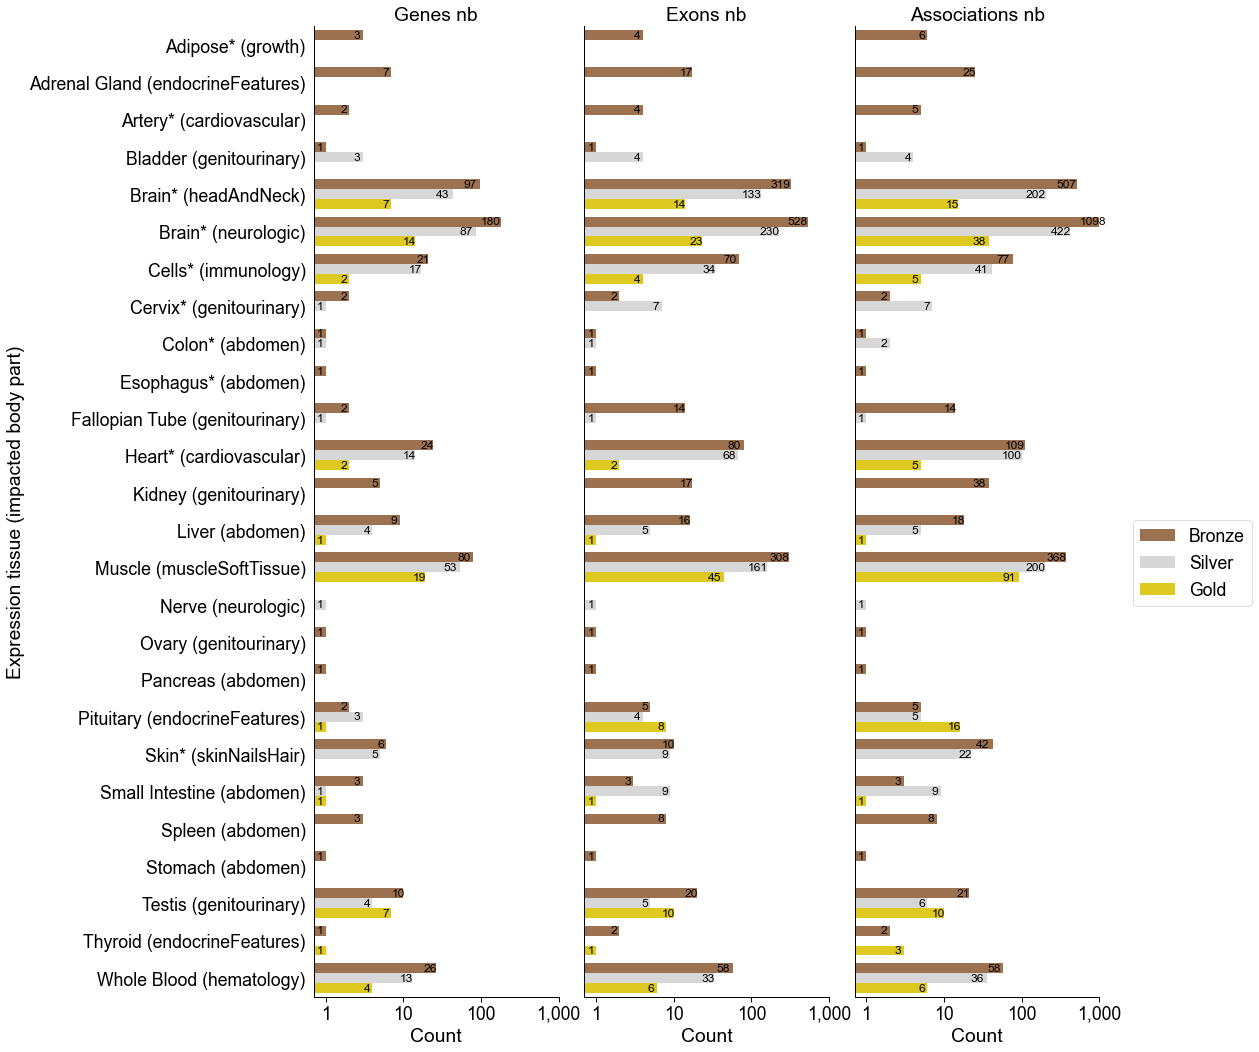

In [124]:
def show_values_on_bars(axs, i=0, fontsize=12, rotation=0):
    def _show_on_single_plot(ax):
        for j, p in enumerate(ax.patches):
            _x = p.get_x() + p.get_width() * 0.75
            if p.get_width() < 35:
                _x = p.get_x() + p.get_width() * 0.85
            _y = p.get_y() + p.get_height() / 2 + 0.075
            if i == 0:
                value = "{:.0f}".format(p.get_width())
            if i == 2:
                value = "{:.2f}".format(p.get_width())
            if int(value) > 0 :
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)

            

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
        
v_profile = pd.read_parquet('/gstock/biolo_datasets/variation/benchmark/Databases/GTEX/V7/GTEx_TPM_V_profile.parquet')
d_t = collections.Counter([e.split(' - ')[0] for e in list(v_profile.columns)[2:-2]])
new_cols = dict()
for c in d_t:
    if d_t[c] > 1:
        new_cols[c] = c + '*'
    else:
        new_cols[c] = c        

        
        
        
exon_level  = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/table_OMIM_exon_level_matrix_corrected.xlsx')
test = list(exon_level.filter(regex='exotic').columns)
exon_level = exon_level[[c for c in exon_level.columns if c not in test]]
# exon_level = exon_level.loc[~exon_level['OMIM_details_exon_level'].str.contains('Sinusitis')]
exon_level

        
sns.set_context("paper", font_scale=2)

        
# f, ax = plt.subplots(figsize=(10,17))

t = exon_level.copy()
t['Threshold'] = t['Threshold'].str.title()

t = t[['OMIM_body_part_exon_level', 'Tissue_exon_level', 'symbol', 'MAP', 'Threshold']]
t['Supertissue_exon'] = t['Tissue_exon_level'].apply(lambda r: r.split(' - ')[0])
t = t.replace(new_cols)
t = t.replace(omim_global_dict)

t2 = t.groupby(['Supertissue_exon', 'OMIM_body_part_exon_level', 'Threshold']).size()
t = t.groupby(['Supertissue_exon', 'OMIM_body_part_exon_level', 'Threshold']).nunique().drop(['OMIM_body_part_exon_level', 'Supertissue_exon', 'Tissue_exon_level', 'Threshold'], axis=1)
t = pd.concat([t, t2], axis=1).reset_index()
t = t.sort_values(by=['symbol', 'MAP', 0], ascending=False)
t


t['Merge_index'] = t[t.columns[0]] + ' (' + t[t.columns[1]] + ')'



t = pd.pivot_table(data=t, index='Merge_index', columns='Threshold', values=['symbol', 'MAP', 0]).fillna(0)

t = t.rename({0 : 'Associations nb', 'symbol' : 'Genes nb', 'MAP' : 'Exons nb'}, axis=1).reset_index()

t = t.melt(id_vars='Merge_index', value_vars=['Genes nb', 'Exons nb', 'Associations nb'])
t.columns = ['Merge_index', 'variable', 'Threshold', 'value']
t

g = sns.FacetGrid(t, col='variable', height=15, aspect=0.35, sharex=True, )
g.map(sns.barplot, 'value', 'Merge_index', 'Threshold',  hue_order=['Bronze', 'Silver', 'Gold'], palette={'Bronze' : "#A77044", 'Silver' : "#D7D7D7", 'Gold': "#FEE101"})
plt.xscale('log')

for ax in g.axes.flatten():
    show_values_on_bars(ax)
    ax.tick_params(axis = "y", which = "both", bottom = False, top = False, left=False, right=False)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.ticklabel_format(axis='x', useOffset=False)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.minorticks_off()
    ax.set_xlim(0,1000)

#     ax.spines['top'].set_linewidth(0)
#     ax.spines['right'].set_linewidth(0)
#     ax.spines['bottom'].set_linewidth(0)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Count", "Expression tissue (impacted body part)")
# # plt.ylabel('Tissue with observed phenotype : gene level (exon level)')
# # plt.xlabel('Count')
# legend = ax.get_legend()
# legend.set_title('')
plt.legend(bbox_to_anchor=(1.1,0.5))

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


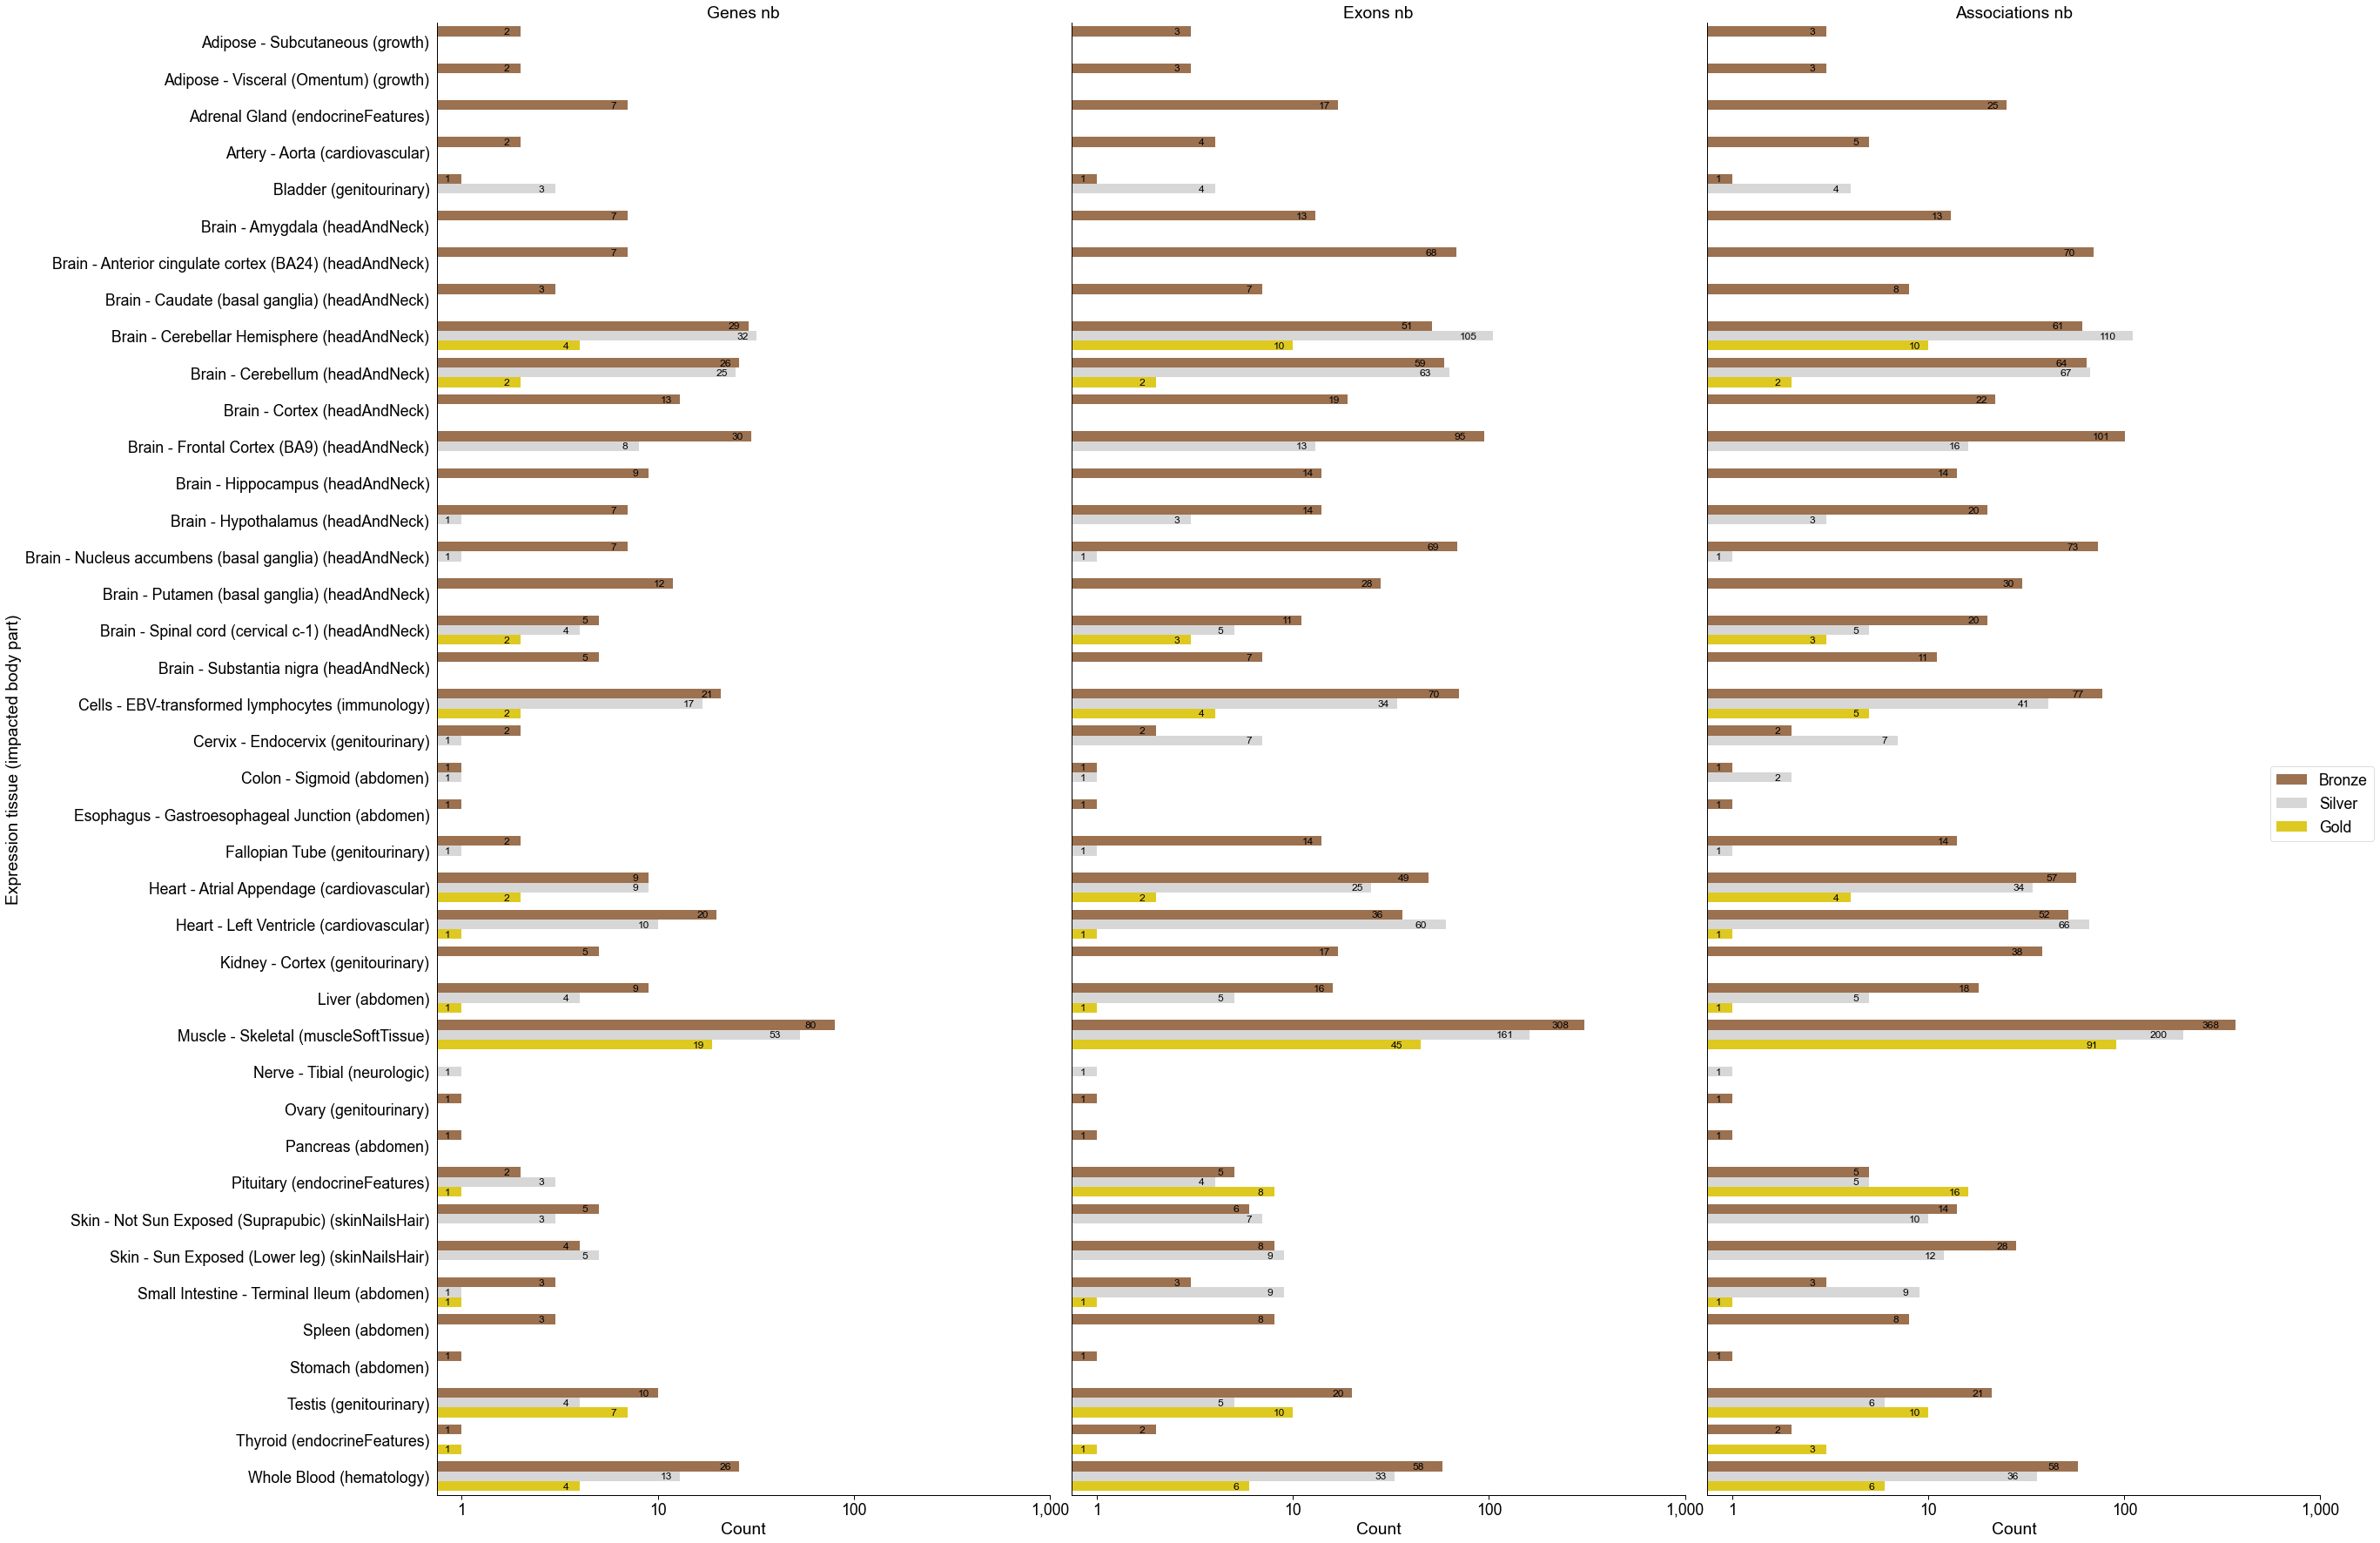

In [27]:
def show_values_on_bars(axs, i=0, fontsize=12, rotation=0):
    def _show_on_single_plot(ax):
        for j, p in enumerate(ax.patches):
            _x = p.get_x() + p.get_width() * 0.75
            if p.get_width() < 35:
                _x = p.get_x() + p.get_width() * 0.85
            _y = p.get_y() + p.get_height() / 2 + 0.075
            if i == 0:
                value = "{:.0f}".format(p.get_width())
            if i == 2:
                value = "{:.2f}".format(p.get_width())
            if int(value) > 0 :
                ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation)

            

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
        
v_profile = pd.read_parquet('/gstock/biolo_datasets/variation/benchmark/Databases/GTEX/V7/GTEx_TPM_V_profile.parquet')
d_t = collections.Counter([e.split(' - ')[0] for e in list(v_profile.columns)[2:-2]])
new_cols = dict()
for c in d_t:
    if d_t[c] > 1:
        new_cols[c] = c + '*'
    else:
        new_cols[c] = c        

        
        
        
exon_level  = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/table_OMIM_exon_level_matrix_corrected.xlsx')
test = list(exon_level.filter(regex='exotic').columns)
exon_level = exon_level[[c for c in exon_level.columns if c not in test]]
# exon_level = exon_level.loc[~exon_level['OMIM_details_exon_level'].str.contains('Sinusitis')]
exon_level

        
sns.set_context("paper", font_scale=2)

        
# f, ax = plt.subplots(figsize=(10,17))

t = exon_level.copy()
t['Threshold'] = t['Threshold'].str.title()

t = t[['OMIM_body_part_exon_level', 'Tissue_exon_level', 'symbol', 'MAP', 'Threshold']]
t['Supertissue_exon'] = t['Tissue_exon_level'].apply(lambda r: r.split(' - ')[0])
t = t.replace(new_cols)
t = t.replace(omim_global_dict)

t2 = t.groupby(['Tissue_exon_level', 'OMIM_body_part_exon_level', 'Threshold']).size()
t = t.groupby(['Tissue_exon_level', 'OMIM_body_part_exon_level', 'Threshold']).nunique().drop(['OMIM_body_part_exon_level', 'Supertissue_exon', 'Tissue_exon_level', 'Threshold'], axis=1)
t = pd.concat([t, t2], axis=1).reset_index()
t = t.sort_values(by=['symbol', 'MAP', 0], ascending=False)
t


t['Merge_index'] = t[t.columns[0]] + ' (' + t[t.columns[1]] + ')'



t = pd.pivot_table(data=t, index='Merge_index', columns='Threshold', values=['symbol', 'MAP', 0]).fillna(0)

t = t.rename({0 : 'Associations nb', 'symbol' : 'Genes nb', 'MAP' : 'Exons nb'}, axis=1).reset_index()

t = t.melt(id_vars='Merge_index', value_vars=['Genes nb', 'Exons nb', 'Associations nb'])
t.columns = ['Merge_index', 'variable', 'Threshold', 'value']
t

g = sns.FacetGrid(t, col='variable', height=25, aspect=0.5, sharex=True, )
g.map(sns.barplot, 'value', 'Merge_index', 'Threshold',  hue_order=['Bronze', 'Silver', 'Gold'], palette={'Bronze' : "#A77044", 'Silver' : "#D7D7D7", 'Gold': "#FEE101"})
plt.xscale('log')

for ax in g.axes.flatten():
    show_values_on_bars(ax)
    ax.tick_params(axis = "y", which = "both", bottom = False, top = False, left=False, right=False)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.ticklabel_format(axis='x', useOffset=False)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.minorticks_off()
    ax.set_xlim(0,1000)

#     ax.spines['top'].set_linewidth(0)
#     ax.spines['right'].set_linewidth(0)
#     ax.spines['bottom'].set_linewidth(0)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Count", "Expression tissue (impacted body part)")
# # plt.ylabel('Tissue with observed phenotype : gene level (exon level)')
# # plt.xlabel('Count')
# legend = ax.get_legend()
# legend.set_title('')
plt.legend(bbox_to_anchor=(1.1,0.5))

In [21]:
exon_level  = pd.read_excel('/gstock/EXOTIC/data/PHENOTYPES/table_OMIM_exon_level_matrix_corrected.xlsx')
exon_level

,symbol,MAP,Corrected_Tissues,OMIM_pheno_exon_level,Threshold,EXOTIC_value,OMIM_pheno_name_exon_level,Tissue_exon_level,OMIM_body_part_exon_level,OMIM_details_exon_level
0,ABCC9,ABCC9_21958108-21958245,['Cells - Cultured fibroblasts' 'Muscle - Skel...,239850,gold,0.997737,Hypertrichotic osteochondrodysplasia,Muscle - Skeletal,muscleSoftTissue,['Lymphedema']
1,ABL1,ABL1_133589707-133589842,['Whole Blood' 'Testis' 'Cells - EBV-transform...,617602,silver,0.983746,Congenital heart defects and skeletal malforma...,Testis,genitourinaryExternalGenitaliaMale,['Hypospadias']
2,ABL1,ABL1_133589707-133589842,['Whole Blood' 'Testis' 'Cells - EBV-transform...,608232,bronze,0.919824,"Leukemia, Philadelphia chromosome-positive, re...",Whole Blood,hematology,"['Chronic myelogenous leukemia', 'Ph-positive ..."
3,ACADVL,ACADVL_7120465-7120492,['Muscle - Skeletal'],201475,silver,0.985499,VLCAD deficiency,Muscle - Skeletal,muscleSoftTissue,"['Hypotonia', 'Muscle weakness associated with..."
4,ACADVL,ACADVL_7121035-7121137,['Muscle - Skeletal'],201475,silver,0.985499,VLCAD deficiency,Muscle - Skeletal,muscleSoftTissue,"['Hypotonia', 'Muscle weakness associated with..."
...,...,...,...,...,...,...,...,...,...,...
2103,WDR4,WDR4_44296812-44296877,['Brain - Frontal Cortex (BA9)' 'Muscle - Skel...,618347,bronze,0.917838,Galloway-Mowat syndrome 6,Brain - Frontal Cortex (BA9),headAndNeckHead,['Microcephaly']
2104,WDR4,WDR4_44296812-44296877,['Brain - Frontal Cortex (BA9)' 'Muscle - Skel...,618346,bronze,0.917838,"Microcephaly, growth deficiency, seizures, and...",Brain - Frontal Cortex (BA9),headAndNeckHead,['Microcephaly (down to -10 SD)']
2105,WDR4,WDR4_44299517-44299605,['Brain - Frontal Cortex (BA9)' 'Muscle - Skel...,618347,bronze,0.917838,Galloway-Mowat syndrome 6,Brain - Frontal Cortex (BA9),headAndNeckHead,['Microcephaly']
2106,WDR4,WDR4_44299517-44299605,['Brain - Frontal Cortex (BA9)' 'Muscle - Skel...,618346,bronze,0.917838,"Microcephaly, growth deficiency, seizures, and...",Brain - Frontal Cortex (BA9),headAndNeckHead,['Microcephaly (down to -10 SD)']


In [22]:
exon_level.loc[exon_level['symbol'] == 'TBC1D24']

,symbol,MAP,Corrected_Tissues,OMIM_pheno_exon_level,Threshold,EXOTIC_value,OMIM_pheno_name_exon_level,Tissue_exon_level,OMIM_body_part_exon_level,OMIM_details_exon_level
1875,TBC1D24,TBC1D24_2547711-2547728,['Brain - Cerebellum' 'Muscle - Skeletal'],220500,bronze,0.902905,DOORS syndrome,Brain - Cerebellum,headAndNeckHead,"['Microcephaly', 'Narrow bifrontal diameter']"
1876,TBC1D24,TBC1D24_2547711-2547728,['Brain - Cerebellum' 'Muscle - Skeletal'],615338,bronze,0.902905,"Epileptic encephalopathy, early infantile, 16",Brain - Cerebellum,headAndNeckHead,"['Microcephaly, acquired (in some patients)']"
1877,TBC1D24,TBC1D24_2547711-2547728,['Brain - Cerebellum' 'Muscle - Skeletal'],615338,gold,0.991508,"Epileptic encephalopathy, early infantile, 16",Muscle - Skeletal,muscleSoftTissue,"['Hypotonia, severe']"


In [98]:
exotic = pd.read_parquet('/gstock/EXOTIC/data/EXOTIC/EXOTIC_2021.parquet')
exotic

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,MAP,mean_proportion,Adipose - Subcutaneous_exotic,Adipose - Visceral (Omentum)_exotic,...,Skin - Not Sun Exposed (Suprapubic)_pextvalue,Skin - Sun Exposed (Lower leg)_pextvalue,Small Intestine - Terminal Ileum_pextvalue,Spleen_pextvalue,Stomach_pextvalue,Testis_pextvalue,Thyroid_pextvalue,Uterus_pextvalue,Vagina_pextvalue,Whole Blood_pextvalue
0,A1CF,ENSG00000148584,24086,52573798-52573822,0.375000,8,A1CF_52573798-52573822,0.030960,NaN,NaN,...,NaN,0.00000,0.16110,NaN,0.00000,0.00000,0.00000,NaN,NaN,NaN
1,A1CF,ENSG00000148584,24086,52610425-52610547,0.375000,8,A1CF_52610425-52610547,0.006439,NaN,NaN,...,NaN,0.00000,0.05501,NaN,0.00000,0.00000,0.00000,NaN,NaN,NaN
2,A1CF,ENSG00000148584,24086,52619602-52619700,0.625000,8,A1CF_52619602-52619700,0.979670,NaN,NaN,...,NaN,1.00000,0.94499,NaN,1.00000,0.66667,1.00000,NaN,NaN,NaN
3,A2ML1,ENSG00000166535,23336,8975248-8975309,0.500000,2,A2ML1_8975248-8975309,0.695140,0.731334,0.731334,...,0.57888,0.54618,1.00000,1.00000,1.00000,0.20471,1.00000,0.43478,0.69070,1.0000
4,A2ML1,ENSG00000166535,23336,8975778-8975961,0.500000,2,A2ML1_8975778-8975961,0.695140,0.731334,0.731334,...,0.57888,0.54618,1.00000,1.00000,1.00000,0.20471,1.00000,0.43478,0.69070,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45049,ZYG11A,ENSG00000203995,32058,53308556-53308645,0.500000,2,ZYG11A_53308556-53308645,0.160540,0.368199,0.368199,...,0.00000,0.16667,0.00000,0.53846,0.00000,0.80328,0.80000,0.00000,0.00000,NaN
45050,ZYG11A,ENSG00000203995,32058,53320137-53320302,0.500000,2,ZYG11A_53320137-53320302,0.160540,0.368199,0.368199,...,0.00000,0.16667,0.00000,0.53846,0.00000,0.80328,0.80000,0.00000,0.00000,NaN
45051,ZYG11A,ENSG00000203995,32058,53322670-53323421,0.500000,2,ZYG11A_53322670-53323421,0.160540,0.368199,0.368199,...,0.00000,0.16667,0.00000,0.53846,0.00000,0.80328,0.80000,0.00000,0.00000,NaN
45052,ZYG11A,ENSG00000203995,32058,53326403-53326421,0.500000,2,ZYG11A_53326403-53326421,0.160540,0.368199,0.368199,...,0.00000,0.16667,0.00000,0.53846,0.00000,0.80328,0.80000,0.00000,0.00000,NaN


In [117]:
pd.options.display.max_rows = 150
exotic.loc[exotic['symbol'] == 'CACNA1C'].T

,5431,5432,5433,5434,5435,5436,5437,5438,5439,5440,5441,5442,5443
symbol,CACNA1C,CACNA1C,CACNA1C,CACNA1C,CACNA1C,CACNA1C,CACNA1C,CACNA1C,CACNA1C,CACNA1C,CACNA1C,CACNA1C,CACNA1C
ensg,ENSG00000151067,ENSG00000151067,ENSG00000151067,ENSG00000151067,ENSG00000151067,ENSG00000151067,ENSG00000151067,ENSG00000151067,ENSG00000151067,ENSG00000151067,ENSG00000151067,ENSG00000151067,ENSG00000151067
HGNC,1390,1390,1390,1390,1390,1390,1390,1390,1390,1390,1390,1390,1390
Exon,2602356-2602365,2613602-2613705,2614008-2614111,2706396-2706455,2706603-2706662,2742795-2742878,2743463-2743540,2743540-2743546,2757641-2757673,2760740-2760806,2783650-2783707,2789529-2789741,2791116-2791220
Ratio_num,0.956522,0.173913,0.826087,0.652174,0.478261,0.434783,0.73913,0.695652,0.73913,0.0434783,0.304348,0.0434783,0.130435
mRNA_nb,23,23,23,23,23,23,23,23,23,23,23,23,23
MAP,CACNA1C_2602356-2602365,CACNA1C_2613602-2613705,CACNA1C_2614008-2614111,CACNA1C_2706396-2706455,CACNA1C_2706603-2706662,CACNA1C_2742795-2742878,CACNA1C_2743463-2743540,CACNA1C_2743540-2743546,CACNA1C_2757641-2757673,CACNA1C_2760740-2760806,CACNA1C_2783650-2783707,CACNA1C_2789529-2789741,CACNA1C_2791116-2791220
mean_proportion,0.76298,0.010972,0.75201,0.75087,0.012125,0.011136,0.74798,0.74754,0.7532,0.00051839,0.0056118,0.0065929,0.0012542
Adipose - Subcutaneous_exotic,0.424061,0.340614,0.447671,0.443787,0.338909,0.383968,0.440305,0.44128,0.440117,0.369473,0.492637,0.321099,0.375829
Adipose - Visceral (Omentum)_exotic,0.511694,0.340614,0.536213,0.531953,0.346667,0.34221,0.530261,0.531208,0.52608,0.369473,0.424394,0.321099,0.375829


In [148]:
clinvar_exotic = pd.read_excel('/gstock/EXOTIC/data/VARIATIONS/genes_clinvar_all_stars.xlsx')
unwanted = ["['Sinusitis']", "['Normal']"]
clinvar_exotic = clinvar_exotic.loc[(~clinvar_exotic['OMIM_details_gene_level'].isin(unwanted)) & (~clinvar_exotic['OMIM_details_exon_level'].isin(unwanted))]
list(clinvar_exotic.columns)
pd.options.display.max_rows = 50




validated_alleles = [
    29539,
    247688,
    166249,
    611822,
    21861,
    805296,


]

clinvar_exotic['Index'] = clinvar_exotic['alleleid'].map(
    {
        29539 : 1,
        247688 : 2,
        166249 : 3,
        611822 : 4,
        21861 : 5,
        805296 : 6,
    }
    
)


clinvar_exotic['Type'] = clinvar_exotic['alleleid'].map(
    {
        29539 : 'Both',
        247688 : 'Both',
        166249 : 'Both',
        611822 : 'DET',
        21861 : 'DET',
        805296 : 'DET',
    }
    
)

clinvar_exotic = clinvar_exotic.loc[clinvar_exotic['alleleid'].isin(validated_alleles)]

clinvar_exotic['PMID'] = clinvar_exotic['alleleid'].map(
    {
        166249 : '20301572 (GeneReviews)',
        213846 : '21396098',
        247688 :  '27328748',
        21861 : '20400963',
        648846 : '23453664',
        611822 : '23526554',   
        805296 : '3812552, 31814248',
        213846 : '21396098',
        18486 : '12827451',
        26598 : '19687455',
        38692 : '21310273',
        359142 : '26168012',
        34227 : '15147384',
        439691 : '29290614',
        27506 : '19047562',
        27488 : '10619715',
        29539 : '22148005',



    }
)


clinvar_exotic['Citation (gene level)'] = clinvar_exotic['alleleid'].map(
    {
        166249 : '"immune abnormalities" / "immunodeficiency"',
        213846 : '""',
        247688 : '"postnatal microcephaly, developmental delay"',
        21861 : '"bilateral cryptorchidism, small genitalia"',
        648846 : '"microcephaly, cerebellar hypoplasia"',
        611822 : '"acquired microcephaly"',
        805296 : '""',
        213846 : '""',
        18486 : '"abnormal genitalia or malformations of the reproductive system (Genereviews / GHR)"',
        26598 : '"postural muscle atrophy"',
        38692 : '""',
        359142 : '""',
        34227 : '"cirrhosis (one of four)"',
        439691 : '""',
        27506 : '"first signs of muscle weakness were observed at age 8 months"',
        27488 : '"extremely hypotonic, are¯exic and almost immobile"',

    }
)


clinvar_exotic['Citation (exon level)'] = clinvar_exotic['alleleid'].map(
    {
        166249 : '"Women with BSyn, although often fertile, may enter menopause prematurely."',
        213846 : '""',
        247688 : '"hyporeactivity, hypotonia and optic atrophy, demyelination"',
        21861 : '"congenital heart defect"',
        648846 : '"bone-marrow failure"',
        611822 : '"severe hypotonia" / "Hypotonia from 3 months"',
        805296 : '""',
        213846 : '""',
        18486 : '"heart defects (Genereviews / GHR)"',
        26598 : '""',
        38692 : '"tubular aggregates in muscle biopsies"',
        359142 : '"muscle wasting stereotypic"',
        34227 : '"diabetes mellitus"',
        439691 : '"proximal limb weakness"',
        27506 : '""',
        27488 : '""',

    }
)

clinvar_exotic['Variant reported'] = clinvar_exotic['alleleid'].map(
    {
        166249 : 'N',
        213846 : 'Y',
        247688 : 'Y',
        21861 : 'Y',
        648846 : 'Y',
        611822 : 'Y',
        805296 : 'Y',
        213846 : 'Y',
        18486 : 'Y',
        26598 : 'Y',
        38692  : 'Y',
        359142 : 'Y',
        34227 : 'Y',
        439691 : 'Y',
        27506 : 'Y',
        27488 : 'Y',
        29539 : 'Y',

    }
)

clinvar_exotic['HGVS prot'] = clinvar_exotic['alleleid'].map(
    {
        166249 : 'NP_000048.1:p.Arg1139Ter',
        213846 : 'NP_003997.1:p.Asn3068fs',
        247688 : 'NP_036192.2:p.Ser36Gly',
        21861 : 'NP_478123.1:p.Arg258His',
        648846 : 'NP_001269938.1:p.Ala1240fs',
        611822 : 'NP_001186036.1:p.Ser324Ter',
        805296 : '	NP_004229.1:p.Arg995Ter',
        213846 : 'NP_003997.1:p.Asn3068fs',
        18486 : 'NP_000126.2:p.Trp171Ter',
        26598 : 'NP_001153174.1:p.Val280Met',
        38692 : 'NP_001231639.1:p.Trp240Ter',
        359142 : 'NP_620128.1:p.His56fs',
        34227 : 'NP_003218.2:p.Arg105Ter',
        439691 : 'NP_004609.1:p.Met100Va',
        27506 : 'NP_001288155.1:p.Asn202Lys	' ,
        27488 : 'NP_689476.2:p.Gln32Ter',
        29539 : 'NP_733821.1:p.Gly608=',

    }
)

clinvar_exotic['HGVS genomic'] = clinvar_exotic['alleleid'].map(
    {
        166249 : 'NM_000057.4:c.3415C>T ',
        213846 : 'NM_004006.2:c.9200_9203CAAA[1]',
        247688 : 'NM_012062.5:c.106A>G',
        21861 : 'NM_058216.3:c.773G>A',
        648846 : 'NM_001283009.1:c.3713_3714TC[1]',
        611822 : 'NM_001199107.2:c.971C>A ',
        805296 : 'NM_004238.3:c.2983C>T',
        213846 : 'NP_003997.1:p.Asn3068fs',
        18486 : 'NM_000135.4:c.513G>A',
        26598 : 'NM_001159702.3:c.838G>A',
        38692 : 'NM_001244710.1:c.719G>A',
        359142 : 'NM_138773.4:c.166dup',
        34227 : 'NM_003227.4:c.313C>T',
        439691 : 'NM_004618.5:c.298A>G',
        27506 : 'NM_001301226.2:c.606C>G' ,
        27488 : 'NM_152263.4:c.94C>T',
        29539 : 'NM_170707.4:c.1824C>T',
    }
)



clinvar_exotic['Comments'] = clinvar_exotic['alleleid'].map(
    {
        166249 : '',
        213846 : '',
        247688 : '',
        21861 : '',
        648846 : '',
        611822 : 'C156X & F229S on const exons with both phenotypes',
        805296 : 'Old paper referencing both macroorchidism & macrocephaly',
        213846 : 'Muscular only',
        18486 : '',
        26598 : 'Muscular only',
        38692 : 'Muscular only',
        359142 : 'Muscular only',
        34227 : '',
        439691 : '',
        27506 : 'Muscular only',
        27488 : 'Muscular only',


    }
)

clinvar_exotic = clinvar_exotic.set_index('Index')
clinvar_exotic = clinvar_exotic.sort_index()

clinvar_exotic = clinvar_exotic[
    [
        'Type',
        'symbol',
        'Exon',
        'Threshold',
        'EXOTIC_value',
#         'mRNA_nb',
#         'Ratio_num',
        'OMIM_pheno_gene_level',
        'OMIM_pheno_name_gene_level',
        'Tissue_gene_level',
        'OMIM_body_part_gene_level',
        'OMIM_details_gene_level',

        'OMIM_pheno_exon_level',
        'OMIM_pheno_name_exon_level',
        'Tissue_exon_level',
        'OMIM_body_part_exon_level',
        'OMIM_details_exon_level',
        'alleleid',
        'RS_STARS',
        'MC',
        'PMID',
        'Variant reported',
#         'Comments',
        'HGVS prot',
        'HGVS genomic',
#         'Citation (gene level)',
#         'Citation (exon level)',
    ]
]

clinvar_exotic.columns = [
        'Identification type',
        'Gene', 
        'Exon (GRCh37)', 
        'EXOTIC threshold', 
        'EXOTIC value', 
#         'mRNA_nb',
#         'Ratio_num',
        'OMIM phenotype ID (gene level)', 
        'OMIM phenotype (gene level)', 
        'Expression dominant tissue (gene level)', 
        'OMIM impacted body part (gene level)', 
        'OMIM detailed (gene level)', 
        
        'OMIM phenotype ID (exon level)', 
        'OMIM phenotype (exon level)', 
        'Tissue-specific expression (exon level)', 
        'OMIM body part (exon level)', 
        'OMIM detailed (exon level)',
    
        'ClinVar AlleleID', 
        'ClinVar Review STARS', 
        'ClinVar Molecular Consquence', 
        'PMID',
        'Variant reported',
#         'Comments',
        'HGVS prot',
        'HGVS genomic',
#         'Citation (gene level)',
#         'Citation (exon level)',
]

clinvar_exotic.to_excel('/gstock/EXOTIC/data/VARIATIONS/paper_results.xlsx', index=False)
clinvar_exotic

,Identification type,Gene,Exon (GRCh37),EXOTIC threshold,EXOTIC value,OMIM phenotype ID (gene level),OMIM phenotype (gene level),Expression dominant tissue (gene level),OMIM impacted body part (gene level),OMIM detailed (gene level),...,Tissue-specific expression (exon level),OMIM body part (exon level),OMIM detailed (exon level),ClinVar AlleleID,ClinVar Review STARS,ClinVar Molecular Consquence,PMID,Variant reported,HGVS prot,HGVS genomic
Index,,,,,,,,,,,,,,,,,,,,,
1.0,Both,LMNA,156108398-156108548,bronze,0.906182,NaN,NaN,NaN,NaN,NaN,...,Skin - Sun Exposed (Lower leg),skinNailsHairSkin,['Absence of subcutaneous fat'],29539,2,synonymous_variant,22148005,Y,NP_733821.1:p.Gly608=,NM_170707.4:c.1824C>T
2.0,Both,DNM1L,32854349-32854452,bronze,0.902562,614388.0,"Encephalopathy, lethal, due to defective mitoc...",Brain - Cerebellar Hemisphere,headAndNeckHead,['Microcephaly'],...,Muscle - Skeletal,muscleSoftTissue,"['Hypotonia', 'Skeletal muscle biopsy shows el...",247688,1,missense_variant,27328748,Y,NP_036192.2:p.Ser36Gly,NM_012062.5:c.106A>G
3.0,Both,BLM,91346751-91346950,silver,0.971954,210900.0,Bloom syndrome,Cells - EBV-transformed lymphocytes,immunology,"['Immunoglobulin deficiency (IgA, IgG, IgM)', ...",...,Cervix - Endocervix,genitourinaryInternalGenitaliaFemale,['Reduced fertility in females'],166249,2,nonsense,20301572 (GeneReviews),N,NP_000048.1:p.Arg1139Ter,NM_000057.4:c.3415C>T
4.0,DET,TBC1D24,2547711-2547728,gold,0.991508,220500.0,DOORS syndrome,Brain - Cerebellar Hemisphere,headAndNeckHead,"['Microcephaly', 'Narrow bifrontal diameter']",...,Muscle - Skeletal,muscleSoftTissue,"['Hypotonia, severe']",611822,1,nonsense,23526554,Y,NP_001186036.1:p.Ser324Ter,NM_001199107.2:c.971C>A
5.0,DET,RAD51C,56787220-56787351,bronze,0.930336,613390.0,"Fanconi anemia, complementation group O",Testis,genitourinaryExternalGenitaliaMale,"['Small genitalia', 'Cryptorchidism']",...,Heart - Left Ventricle,cardiovascularHeart,['Congenital heart defect'],21861,2,missense_variant,20400963,Y,NP_478123.1:p.Arg258His,NM_058216.3:c.773G>A
6.0,DET,TRIP12,230663999-230664099,silver,0.955402,617752.0,"Mental retardation, autosomal dominant 49",Testis,genitourinaryExternalGenitaliaMale,['Macroorchidism'],...,Brain - Cerebellar Hemisphere,headAndNeckHead,['Macrocephaly'],805296,1,nonsense,"3812552, 31814248",Y,\tNP_004229.1:p.Arg995Ter,NM_004238.3:c.2983C>T


In [83]:
clinvar_exotic = pd.read_excel('/gstock/EXOTIC/data/VARIATIONS/genes_clinvar_all_stars.xlsx')
unwanted = ["['Sinusitis']", "['Normal']"]
clinvar_exotic = clinvar_exotic.loc[(~clinvar_exotic['OMIM_details_gene_level'].isin(unwanted)) & (~clinvar_exotic['OMIM_details_exon_level'].isin(unwanted))]
list(clinvar_exotic.columns)
pd.options.display.max_rows = 50

validated_alleles = [
    166249,
    213846,
    247688,
    21861,
    648846,
    611822,
    805296,
    213846,
    18486,
    26598,
    38692,
    359142,
    34227,
    439691,
    27506,
    27488,
]


clinvar_exotic = clinvar_exotic.loc[clinvar_exotic['alleleid'].isin(validated_alleles)]

clinvar_exotic['PMID'] = clinvar_exotic['alleleid'].map(
    {
        166249 : '20301572 (GeneReviews)',
        213846 : '21396098',
        247688 :  '27328748',
        21861 : '20400963',
        648846 : '23453664',
        611822 : '23526554',   
        805296 : '3812552 (Year:1987)',
        213846 : '21396098',
        18486 : '12827451',
        26598 : '19687455',
        38692 : '21310273',
        359142 : '26168012',
        34227 : '15147384',
        439691 : '29290614',
        27506 : '19047562',
        27488 : '10619715',



    }
)


clinvar_exotic['Citation (gene level)'] = clinvar_exotic['alleleid'].map(
    {
        166249 : '"immune abnormalities" / "immunodeficiency"',
        213846 : '""',
        247688 : '"postnatal microcephaly, developmental delay"',
        21861 : '"bilateral cryptorchidism, small genitalia"',
        648846 : '"microcephaly, cerebellar hypoplasia"',
        611822 : '"acquired microcephaly"',
        805296 : '""',
        213846 : '""',
        18486 : '"abnormal genitalia or malformations of the reproductive system (Genereviews / GHR)"',
        26598 : '"postural muscle atrophy"',
        38692 : '""',
        359142 : '""',
        34227 : '"cirrhosis (one of four)"',
        439691 : '""',
        27506 : '"first signs of muscle weakness were observed at age 8 months"',
        27488 : '"extremely hypotonic, are¯exic and almost immobile"',

    }
)


clinvar_exotic['Citation (exon level)'] = clinvar_exotic['alleleid'].map(
    {
        166249 : '"Women with BSyn, although often fertile, may enter menopause prematurely."',
        213846 : '""',
        247688 : '"hyporeactivity, hypotonia and optic atrophy, demyelination"',
        21861 : '"congenital heart defect"',
        648846 : '"bone-marrow failure"',
        611822 : '"severe hypotonia" / "Hypotonia from 3 months"',
        805296 : '""',
        213846 : '""',
        18486 : '"heart defects (Genereviews / GHR)"',
        26598 : '""',
        38692 : '"tubular aggregates in muscle biopsies"',
        359142 : '"muscle wasting stereotypic"',
        34227 : '"diabetes mellitus"',
        439691 : '"proximal limb weakness"',
        27506 : '""',
        27488 : '""',

    }
)

clinvar_exotic['Variant reported'] = clinvar_exotic['alleleid'].map(
    {
        166249 : 'N',
        213846 : 'Y',
        247688 : 'Y',
        21861 : 'Y',
        648846 : 'Y',
        611822 : 'N',
        805296 : 'N',
        213846 : 'Y',
        18486 : 'Y',
        26598 : 'Y',
        38692  : 'Y',
        359142 : 'Y',
        34227 : 'Y',
        439691 : 'Y',
        27506 : 'Y',
        27488 : 'Y',

    }
)

clinvar_exotic['HGVS prot'] = clinvar_exotic['alleleid'].map(
    {
        166249 : 'NP_000048.1:p.Arg1139Ter',
        213846 : 'NP_003997.1:p.Asn3068fs',
        247688 : 'NP_036192.2:p.Ser36Gly',
        21861 : 'NP_478123.1:p.Arg258His',
        648846 : 'NP_001269938.1:p.Ala1240fs',
        611822 : 'NP_001186036.1:p.Ser324Ter',
        805296 : 'NP_001335252.1:p.Arg1070Ter',
        213846 : 'NP_003997.1:p.Asn3068fs',
        18486 : 'NP_000126.2:p.Trp171Ter',
        26598 : 'NP_001153174.1:p.Val280Met',
        38692 : 'NP_001231639.1:p.Trp240Ter',
        359142 : 'NP_620128.1:p.His56fs',
        34227 : 'NP_003218.2:p.Arg105Ter',
        439691 : 'NP_004609.1:p.Met100Va',
        27506 : 'NP_001288155.1:p.Asn202Lys	' ,
        27488 : 'NP_689476.2:p.Gln32Ter',

    }
)

clinvar_exotic['HGVS genomic'] = clinvar_exotic['alleleid'].map(
    {
        166249 : 'NM_000057.4:c.3415C>T ',
        213846 : 'NM_004006.2:c.9200_9203CAAA[1]',
        247688 : 'NM_012062.5:c.106A>G',
        21861 : 'NM_058216.3:c.773G>A',
        648846 : 'NM_001283009.1:c.3713_3714TC[1]',
        611822 : 'NM_001199107.2:c.971C>A ',
        805296 : 'NM_001348323.3:c.3208C>T',
        213846 : 'NP_003997.1:p.Asn3068fs',
        18486 : 'NM_000135.4:c.513G>A',
        26598 : 'NM_001159702.3:c.838G>A',
        38692 : 'NM_001244710.1:c.719G>A',
        359142 : 'NM_138773.4:c.166dup',
        34227 : 'NM_003227.4:c.313C>T',
        439691 : 'NM_004618.5:c.298A>G',
        27506 : 'NM_001301226.2:c.606C>G' ,
        27488 : 'NM_152263.4:c.94C>T',

    }
)



clinvar_exotic['Comments'] = clinvar_exotic['alleleid'].map(
    {
        166249 : '',
        213846 : '',
        247688 : '',
        21861 : '',
        648846 : '',
        611822 : 'C156X & F229S on const exons with both phenotypes',
        805296 : 'Old paper referencing both macroorchidism & macrocephaly',
        213846 : 'Muscular only',
        18486 : '',
        26598 : 'Muscular only',
        38692 : 'Muscular only',
        359142 : 'Muscular only',
        34227 : '',
        439691 : '',
        27506 : 'Muscular only',
        27488 : 'Muscular only',


    }
)



clinvar_exotic = clinvar_exotic[
    [
        'symbol',
        'Exon',
        'mRNA_nb',
        'Ratio_num',
        'OMIM_pheno_gene_level',
        'OMIM_pheno_name_gene_level',
        'Tissue_gene_level',
        'OMIM_body_part_gene_level',
        'OMIM_details_gene_level',
        'Threshold',
        'EXOTIC_value',
        'OMIM_pheno_exon_level',
        'OMIM_pheno_name_exon_level',
        'Tissue_exon_level',
        'OMIM_body_part_exon_level',
        'OMIM_details_exon_level',
        'alleleid',
        'RS_STARS',
        'MC',
        'PMID',
        'Variant reported',
        'Comments',
        'HGVS prot',
        'HGVS genomic',
        'Citation (gene level)',
        'Citation (exon level)',
    ]
]

clinvar_exotic.columns = [
        'Gene', 
        'Exon (GRCh37)', 
        'mRNA_nb',
        'Ratio_num',
        'OMIM phenotype ID (gene level)', 
        'OMIM phenotype (gene level)', 
        'Expression dominant tissue (gene level)', 
        'OMIM impacted body part (gene level)', 
        'OMIM detailed (gene level)', 
        'EXOTIC threshold', 
        'EXOTIC value', 
        'OMIM phenotype ID (exon level)', 
        'OMIM phenotype (exon level)', 
        'Tissue-specific expression (exon level)', 
        'OMIM body part (exon level)', 
        'OMIM detailed (exon level)',
        'ClinVar AlleleID', 
        'ClinVar Review STARS', 
        'ClinVar Molecular Consquence', 
        'PMID',
        'Variant reported',
        'Comments',
        'HGVS prot',
        'HGVS genomic',
        'Citation (gene level)',
        'Citation (exon level)',
]

clinvar_exotic.to_excel('/gstock/EXOTIC/data/VARIATIONS/paper_results.xlsx', index=False)
clinvar_exotic

,Gene,Exon (GRCh37),mRNA_nb,Ratio_num,OMIM phenotype ID (gene level),OMIM phenotype (gene level),Expression dominant tissue (gene level),OMIM impacted body part (gene level),OMIM detailed (gene level),EXOTIC threshold,...,ClinVar AlleleID,ClinVar Review STARS,ClinVar Molecular Consquence,PMID,Variant reported,Comments,HGVS prot,HGVS genomic,Citation (gene level),Citation (exon level)
957,BLM,91346751-91346950,4,0.750000,210900,Bloom syndrome,Cells - EBV-transformed lymphocytes,immunology,"['Immunoglobulin deficiency (IgA, IgG, IgM)', ...",silver,...,166249,2,nonsense,20301572 (GeneReviews),N,,NP_000048.1:p.Arg1139Ter,NM_000057.4:c.3415C>T,"""immune abnormalities"" / ""immunodeficiency""","""Women with BSyn, although often fertile, may ..."
1001,DMD,31341715-31341775,17,0.705882,310200,Duchenne muscular dystrophy,Nerve - Tibial,neurologicPeripheralNervousSystem,"['Hypotonia', 'Waddling gait', 'Hyporeflexia',...",silver,...,213846,2,frameshift_variant,21396098,Y,Muscular only,NP_003997.1:p.Asn3068fs,NP_003997.1:p.Asn3068fs,"""""",""""""
1101,DNM1L,32854349-32854452,8,0.875000,614388,"Encephalopathy, lethal, due to defective mitoc...",Brain - Cerebellar Hemisphere,headAndNeckHead,['Microcephaly'],bronze,...,247688,1,missense_variant,27328748,Y,,NP_036192.2:p.Ser36Gly,NM_012062.5:c.106A>G,"""postnatal microcephaly, developmental delay""","""hyporeactivity, hypotonia and optic atrophy, ..."
1107,FANCA,89877115-89877210,4,0.750000,227650,"Fanconi anemia, complementation group A",Testis,genitourinaryExternalGenitaliaMale,['Cryptorchidism'],bronze,...,18486,0,nonsense,12827451,Y,,NP_000126.2:p.Trp171Ter,NM_000135.4:c.513G>A,"""abnormal genitalia or malformations of the re...","""heart defects (Genereviews / GHR)"""
1123,FHL1,135291402-135291601,15,0.266667,300280,?Uruguay faciocardiomusculoskeletal syndrome,Muscle - Skeletal,muscleSoftTissue,['Marked muscular hypertrophy'],bronze,...,26598,0,missense_variant,19687455,Y,Muscular only,NP_001153174.1:p.Val280Met,NM_001159702.3:c.838G>A,"""postural muscle atrophy""",""""""
1124,GFPT1,69581391-69581444,2,0.500000,610542,"Myasthenia, congenital, 12, with tubular aggre...",Cells - EBV-transformed lymphocytes,immunology,['Absence of acetylcholine receptor (AChR) aut...,gold,...,38692,0,nonsense,21310273,Y,Muscular only,NP_001231639.1:p.Trp240Ter,NM_001244710.1:c.719G>A,"""""","""tubular aggregates in muscle biopsies"""
1146,RAD51C,56787220-56787351,2,0.500000,613390,"Fanconi anemia, complementation group O",Testis,genitourinaryExternalGenitaliaMale,"['Small genitalia', 'Cryptorchidism']",bronze,...,21861,2,missense_variant,20400963,Y,,NP_478123.1:p.Arg258His,NM_058216.3:c.773G>A,"""bilateral cryptorchidism, small genitalia""","""congenital heart defect"""
1163,RTEL1,62326833-62327003,4,0.250000,615190,"Dyskeratosis congenita, autosomal recessive 5",Brain - Cerebellar Hemisphere,headAndNeckHead,['Microcephaly'],bronze,...,648846,1,frameshift_variant,23453664,Y,,NP_001269938.1:p.Ala1240fs,NM_001283009.1:c.3713_3714TC[1],"""microcephaly, cerebellar hypoplasia""","""bone-marrow failure"""
1166,SLC25A46,110074821-110075103,3,0.666667,616505,"Neuropathy, hereditary motor and sensory, type...",Brain - Cerebellar Hemisphere,headAndNeckHead,['Bitemporal narrowing (patient A)'],bronze,...,359142,0,frameshift_variant,26168012,Y,Muscular only,NP_620128.1:p.His56fs,NM_138773.4:c.166dup,"""""","""muscle wasting stereotypic"""
1180,TBC1D24,2547711-2547728,2,0.500000,220500,DOORS syndrome,Brain - Cerebellar Hemisphere,headAndNeckHead,"['Microcephaly', 'Narrow bifrontal diameter']",gold,...,611822,1,nonsense,23526554,N,C156X & F229S on const exons with both phenotypes,NP_001186036.1:p.Ser324Ter,NM_001199107.2:c.971C>A,"""acquired microcephaly""","""severe hypotonia"" / ""Hypotonia from 3 months"""


In [89]:
muscle_genes = ["ABHD5", "ACAD9", "ACADVL", "ACTA1", "ACTA1", "ACTN2", "ACTN2", "ACVR1", "ADSSL1", "AGL", "AGRN", "ALG14", "ALG2", "ANO5", "ANO5", "ATP1A2", "B3GALNT2", "B4GAT1", "BAG3", "BIN1", "BVES", "CACNA1A", "CACNA1H", "CACNA1S", "CACNA1S", "CAPN3", "CASQ1", "CAV3", "CAV3", "CAV3", "CAVIN1", "CCDC78", "CFL2", "CHAT", "CHKB", "CHRNA1", "CHRNB1", "CHRND", "CHRNE", "CHRNG", "CLCN1", "CLN3", "CNTN1", "COL12A1", "COL13A1", "COL6A1", "COL6A1", "COL6A2", "COL6A2", "COL6A3", "COL6A3", "COLQ", "CPT2", "CRYAB", "DAG1", "DAG1", "DES", "DES", "DMD", "DNAJB6", "DNAJB6", "DNM2", "DNM2", "DNM2", "DOK7", "DPAGT1", "DPM1", "DPM2", "DPM3", "DUX4", "DYSF", "DYSF", "EMD", "ENO3", "ETFA", "ETFB", "ETFDH", "FHL1", "FHL1", "FKRP", "FKRP", "FKTN", "FKTN", "FLAD1", "FLNC", "FLNC", "FXR1", "GAA", "GAA", "GBE1", "GFPT1", "GIPC1", "GMPPB", "GMPPB", "GMPPB", "GNE", "GOLGA2", "GOSR2", "GYG1", "GYS1", "HACD1", "HNRNPA1", "HNRNPA2B1", "HNRNPDL", "HRAS", "HSPB8", "INPP5K", "ISCU", "ISPD", "ISPD", "ITGA7", "KBTBD13", "KBTBD13", "KCNA1", "KCNE3", "KCNJ18", "KLHL40", "KLHL41", "KLHL9", "KY", "LAMA2", "LAMA2", "LAMA5", "LAMB2", "LAMP2", "LARGE1", "LDB3", "LDB3", "LDHA", "LIMS2", "LMNA", "LMNA", "LMOD3", "LPIN1", "LRP12", "LRP4", "MAP3K20", "MATR3", "MB", "MEGF10", "MPDU1", "MSTN", "MSTO1", "MTM1", "MUSK", "MYBPC3", "MYH2", "MYH7", "MYH7", "MYL1", "MYL2", "MYMK", "MYO18B", "MYO9A", "MYOT", "MYOT", "MYOT", "MYPN", "NEB", "NEB", "ORAI1", "PABPN1", "PAX7", "PFKM", "PGAM2", "PGK1", "PGM1", "PHKA1", "PLEC", "PLEC", "PLEC", "PNPLA2", "PNPLA8", "POGLUT1", "POMGNT1", "POMGNT1", "POMGNT2", "POMGNT2", "POMK", "POMK", "POMT1", "POMT1", "POMT2", "POMT2", "POPDC3", "PREPL", "PRKAG2", "PYGM", "PYROXD1", "PYROXD1", "PYROXD1", "RAPSN", "RBCK1", "RPH3A", "RXYLT1", "RYR1", "RYR1", "RYR1", "RYR3", "SCN4A", "SCN4A", "SCN4A", "SELENON", "SELENON", "SELENON", "SGCA", "SGCB", "SGCD", "SGCG", "SLC16A1", "SLC18A3", "SLC22A5", "SLC25A1", "SLC25A20", "SLC5A7", "SMCHD1", "SNAP25", "SPEG", "SPTBN4", "SQSTM1", "STAC3", "STIM1", "SVIL", "SYNE1", "SYNE2", "SYT2", "TCAP", "TCAP", "TIA1", "TMEM43", "TNNT1", "TNPO3", "TNPO3", "TOR1AIP1", "TPM2", "TPM3", "TRAPPC11", "TRAPPC11", "TRIM32", "TRIM32", "TRIM54", "TRIM63", "TRIP4", "TTN", "TTN", "TTN", "TTN", "UNC13A", "UNC45B", "VAMP1", "VCP", "VCP", "VCP", "VMA21", ]

In [96]:
clinvar_exotic = pd.read_excel('/gstock/EXOTIC/data/VARIATIONS/genes_clinvar_exon_level_neurologic.xlsx')
unwanted = ["['Sinusitis']", "['Normal']"]
clinvar_exotic = clinvar_exotic.loc[(~clinvar_exotic['OMIM_details_exon_level'].isin(unwanted)) & (clinvar_exotic['OMIM_body_part_exon_level'] != "muscleSoftTissue")]
clinvar_exotic = clinvar_exotic.loc[clinvar_exotic['symbol'].isin(muscle_genes)]
print(clinvar_exotic.symbol.nunique())
print(clinvar_exotic.symbol.unique())
pd.options.display.max_rows = 100
clinvar_exotic.to_excel('/gstock/EXOTIC/data/VARIATIONS/genes_clinvar_exon_level_neurologic_filter.xlsx', index=False)
clinvar_exotic

11
['FHL1' 'LMNA' 'NEB' 'PLEC' 'POMGNT1' 'POMT1' 'PRKAG2' 'RBCK1' 'SPEG'
 'SYNE1' 'TPM3']


,symbol,MAP,Corrected_Tissues,OMIM_pheno_exon_level,Threshold,EXOTIC_value,OMIM_pheno_name_exon_level,Tissue_exon_level,OMIM_body_part_exon_level,OMIM_details_exon_level,Exon,rs,Status,Real_Status,RS_STARS,CLNREVSTAT,HPO,MC,alleleid
1560,FHL1,FHL1_135291402-135291601,['Brain - Cortex' 'Brain - Cerebellum' 'Brain ...,300280,bronze,0.932543,?Uruguay faciocardiomusculoskeletal syndrome,Brain - Cortex,headAndNeckHead,['Brachyturricephaly'],135291402-135291601,2.676068e+08,Pathogenic,Pathogenic,0,no_assertion_criteria_provided,[],missense_variant,26598
1877,LMNA,LMNA_156108279-156108398,['Skin - Sun Exposed (Lower leg)'],176670,bronze,0.905630,Hutchinson-Gilford progeria,Skin - Sun Exposed (Lower leg),skinNailsHairSkin,['Absence of subcutaneous fat'],156108279-156108398,5.783098e+07,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],missense_variant,29533
1878,LMNA,LMNA_156108279-156108398,['Skin - Sun Exposed (Lower leg)'],176670,bronze,0.905630,Hutchinson-Gilford progeria,Skin - Sun Exposed (Lower leg),skinNailsHairSkin,['Absence of subcutaneous fat'],156108279-156108398,7.970445e+08,Pathogenic,Pathogenic,0,no_assertion_criteria_provided,[],missense_variant,172112
1879,LMNA,LMNA_156108279-156108398,['Skin - Sun Exposed (Lower leg)'],176670,bronze,0.905630,Hutchinson-Gilford progeria,Skin - Sun Exposed (Lower leg),skinNailsHairSkin,['Absence of subcutaneous fat'],156108279-156108398,7.862054e+08,Pathogenic,Likely_pathogenic,0,no_assertion_criteria_provided,[],missense_variant,188793
1880,LMNA,LMNA_156108279-156108398,['Skin - Sun Exposed (Lower leg)'],176670,bronze,0.905630,Hutchinson-Gilford progeria,Skin - Sun Exposed (Lower leg),skinNailsHairSkin,['Absence of subcutaneous fat'],156108279-156108398,1.064796e+09,Pathogenic,Likely_pathogenic,1,"criteria_provided,_single_submitter",[],splice_donor_variant,404952
1881,LMNA,LMNA_156108398-156108548,['Skin - Sun Exposed (Lower leg)'],176670,bronze,0.906182,Hutchinson-Gilford progeria,Skin - Sun Exposed (Lower leg),skinNailsHairSkin,['Absence of subcutaneous fat'],156108398-156108548,8.632250e+08,Pathogenic,Pathogenic,2,"criteria_provided,_multiple_submitters,_no_con...",[],frameshift_variant,77775
1882,LMNA,LMNA_156108398-156108548,['Skin - Sun Exposed (Lower leg)'],176670,bronze,0.906182,Hutchinson-Gilford progeria,Skin - Sun Exposed (Lower leg),skinNailsHairSkin,['Absence of subcutaneous fat'],156108398-156108548,8.035681e+07,Pathogenic,Pathogenic,0,no_assertion_criteria_provided,[],synonymous_variant,77772
1883,LMNA,LMNA_156108398-156108548,['Skin - Sun Exposed (Lower leg)'],176670,bronze,0.906182,Hutchinson-Gilford progeria,Skin - Sun Exposed (Lower leg),skinNailsHairSkin,['Absence of subcutaneous fat'],156108398-156108548,5.926778e+07,Pathogenic,Pathogenic,0,no_assertion_criteria_provided,[],missense_variant,77766
1884,LMNA,LMNA_156108398-156108548,['Skin - Sun Exposed (Lower leg)'],176670,bronze,0.906182,Hutchinson-Gilford progeria,Skin - Sun Exposed (Lower leg),skinNailsHairSkin,['Absence of subcutaneous fat'],156108398-156108548,7.970445e+08,Pathogenic,Pathogenic,0,no_assertion_criteria_provided,[],synonymous_variant,172113
1885,LMNA,LMNA_156108398-156108548,['Skin - Sun Exposed (Lower leg)'],176670,bronze,0.906182,Hutchinson-Gilford progeria,Skin - Sun Exposed (Lower leg),skinNailsHairSkin,['Absence of subcutaneous fat'],156108398-156108548,6.106413e+07,Pathogenic,Pathogenic,0,no_assertion_criteria_provided,[],missense_variant,29540
